In [ ]:
Mimport numpy as np
from __future__ import print_function, division
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import interp1d, interp2d
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib notebook

In [ ]:
def wd_model(mass, age, filt):
    """
    Read in white dwarf model and use mass and age to interpolate correct magnitude in filt
    """
    #First put age in yr
    age = age*1.e9
    
    if mass > 1.2:
        return -99.
    
    #read in upper and lower mass bound model files
    if mass < 1.2 and mass > 1.0:
        mbounds = (1.0, 1.2)
    else:
        mbounds = (np.floor(10.*mass)/10., np.floor(10.*mass)/10. + 0.1)
    
    files = ['WD_Tables\Table_Mass_{}'.format(m) for m in mbounds]
    mags = []
    #print files
    
    for file in files:
        mdf = pd.read_csv(file, delim_whitespace=True)
        mfunc = interp1d(mdf['Age'].values[::-1], mdf[filt].values[::-1])
        mmag = mfunc([age])  #This is the mag in filt if m=mbound
        mags += [mmag[0]]
        
    #Now interpolate between the magnitudes from the low mass and high mass cases
    fract = (mass - mbounds[0])/(mbounds[1]-mbounds[0])
    plus = fract * (mags[1]-mags[0])
    mymag = mags[0] + plus
    
    return mymag #This is an absolute magnitude

## Tests

In [ ]:
files = ['WD_Tables\Table_Mass_{:.1f}'.format(m) for m in np.arange(0.2, 1.2, 0.1)]
mdf = pd.read_csv(files[0], header=1, usecols=['Teff', 'Mbol','H', 'K', 'Age'], 
                  delim_whitespace=True)
rw = np.where(mdf['Teff'] == 'Teff')[0][0] # [0] is the first list where Teff happens, the second [0] is the first number that Teff happens to have 
mdf = mdf.drop([rw-1, rw])
mdf['Mbol'].values
mdf

Teff    Mbol       H       K        Age
0    1500.  19.149  20.048  22.217  1.418E+10
1    1750.  18.478  19.026  20.648  1.166E+10
2    2000.  17.896  18.137  19.317  9.847E+09
3    2250.  17.383  17.322  18.118  8.347E+09
4    2500.  16.923  16.716  17.283  6.953E+09
..     ...     ...     ...     ...        ...
82  26000.   5.901   9.325   9.380  0.000E+00
83  27000.   5.713   9.262   9.319  0.000E+00
84  28000.   5.532   9.200   9.259  0.000E+00
85  29000.   5.356   9.139   9.199  0.000E+00
86  30000.   5.185   9.077   9.139  0.000E+00

[85 rows x 5 columns]

In [ ]:
mdf['Mbol'] = np.log10(10**(-(mdf['Mbol'].astype(float) - 4.75)/2.5 ))
mdf = mdf.rename({'Mbol': 'logL'}, axis=1)
mdf

Teff    logL       H       K        Age
0    1500. -5.7596  20.048  22.217  1.418E+10
1    1750. -5.4912  19.026  20.648  1.166E+10
2    2000. -5.2584  18.137  19.317  9.847E+09
3    2250. -5.0532  17.322  18.118  8.347E+09
4    2500. -4.8692  16.716  17.283  6.953E+09
..     ...     ...     ...     ...        ...
82  26000. -0.4604   9.325   9.380  0.000E+00
83  27000. -0.3852   9.262   9.319  0.000E+00
84  28000. -0.3128   9.200   9.259  0.000E+00
85  29000. -0.2424   9.139   9.199  0.000E+00
86  30000. -0.1740   9.077   9.139  0.000E+00

[85 rows x 5 columns]

## HR Diagrams

In [ ]:
files = ['WD_Tables\Table_Mass_{:.1f}'.format(m) for m in np.arange(0.2, 1.2, 0.1)]

def plotter2D(xcol, ycol):
    for file in files:
        mdf = pd.read_csv(file, header=1, usecols=['Teff', 'Mbol','H', 'K', 'Age'], delim_whitespace=True)
        # Remove additional headers
        rw = np.where(mdf['Teff'] == 'Teff')[0][0]
        mdf = mdf.drop([rw-1, rw])

        # Get Log L
        mdf['Mbol'] = np.log10(10**(-(mdf['Mbol'].astype(float) - 4.75)/2.5))
        mdf = mdf.rename({'Mbol': 'logL'}, axis=1)

        # Print HR driagrams
        plt.plot(mdf[xcol][:rw-1].astype(float), mdf[ycol][:rw-1].astype(float), label=file)
        #plt.plot(mdf[xcol][rw-1:].astype(float), mdf[ycol][rw-1:].astype(float), color='r', label="helium")
        plt.title(file[-3:] + " Model")
        plt.gca().invert_xaxis()
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        #plt.yscale('log')
        plt.legend()
        plt.show()

#plotter2D('Teff', 'logL')

<IPython.core.display.Javascript object>


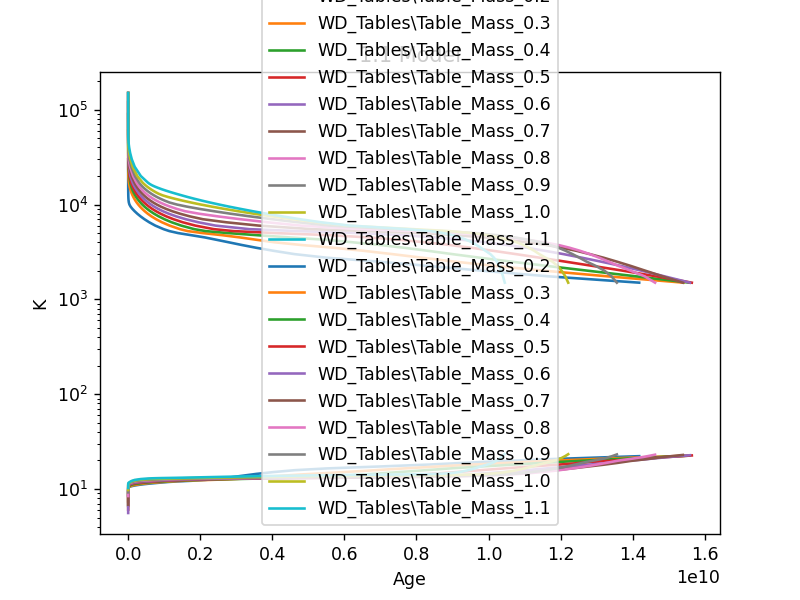

In [ ]:
plotter2D('Age', 'Teff')

<IPython.core.display.Javascript object>


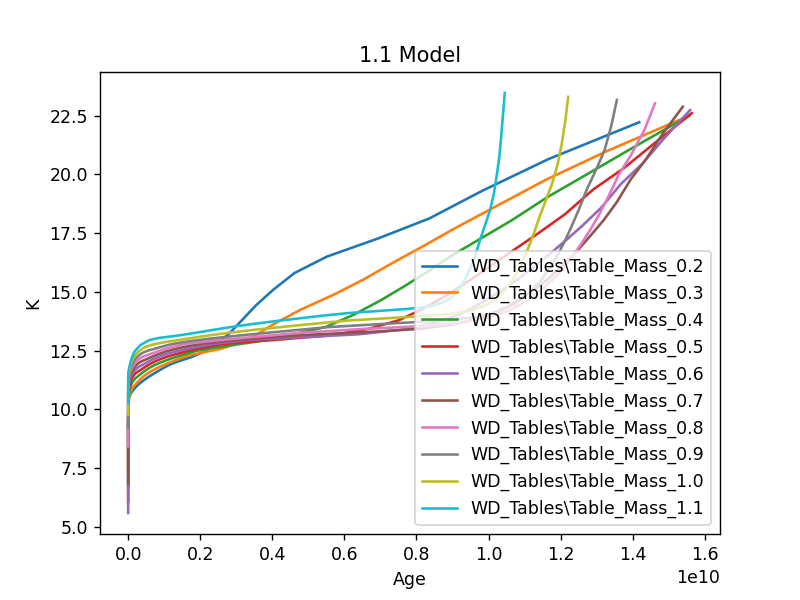

In [ ]:
plotter2D('Age', 'K')

<IPython.core.display.Javascript object>


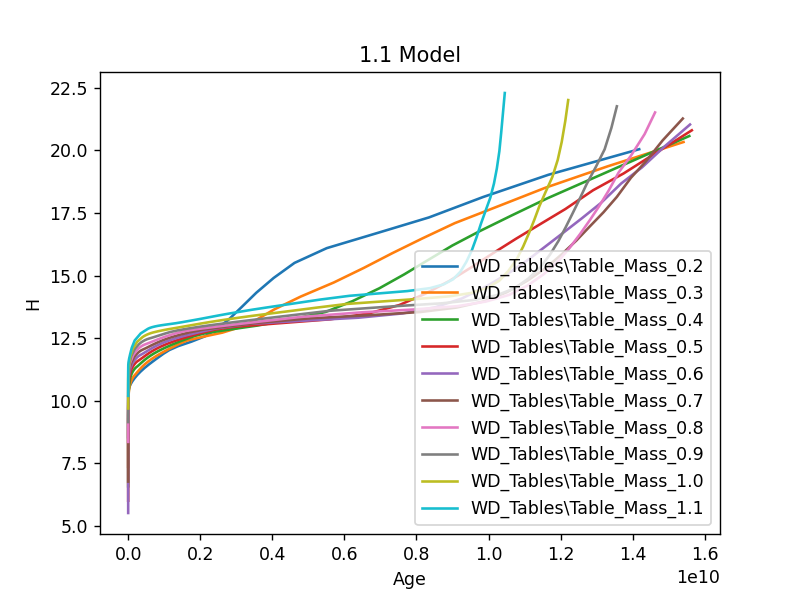

In [ ]:
plotter2D('Age', 'H')

In [ ]:
def plotter3D(xcol, ycol, zcol):
    for file in files:
        mdf = pd.read_csv(file, header=1, usecols=['Teff', 'Mbol','H', 'K', 'Age'], delim_whitespace=True)
        # Remove additional headers
        rw = np.where(mdf['Teff'] == 'Teff')[0][0]
        mdf = mdf.drop([rw-1, rw])

        # Get Log L
        mdf['Mbol'] = np.log10(10**(-(mdf['Mbol'].astype(float) - 4.75)/2.5) * (3.8e26))
        mdf = mdf.rename({'Mbol': 'logL'}, axis=1)

        # 3D Diagrams
        fig = plt.figure(figsize=(8,10))
        ax = plt.axes(projection='3d')
        ax.plot3D(mdf[xcol][:rw-1].astype(float), mdf[ycol][:rw-1].astype(float), mdf[zcol][:rw-1].astype(float))
        plt.title(file[-3:] + " Model")
        ax.set_xlabel(xcol)
        ax.set_ylabel(ycol)
        ax.set_zlabel(zcol)

<IPython.core.display.Javascript object>


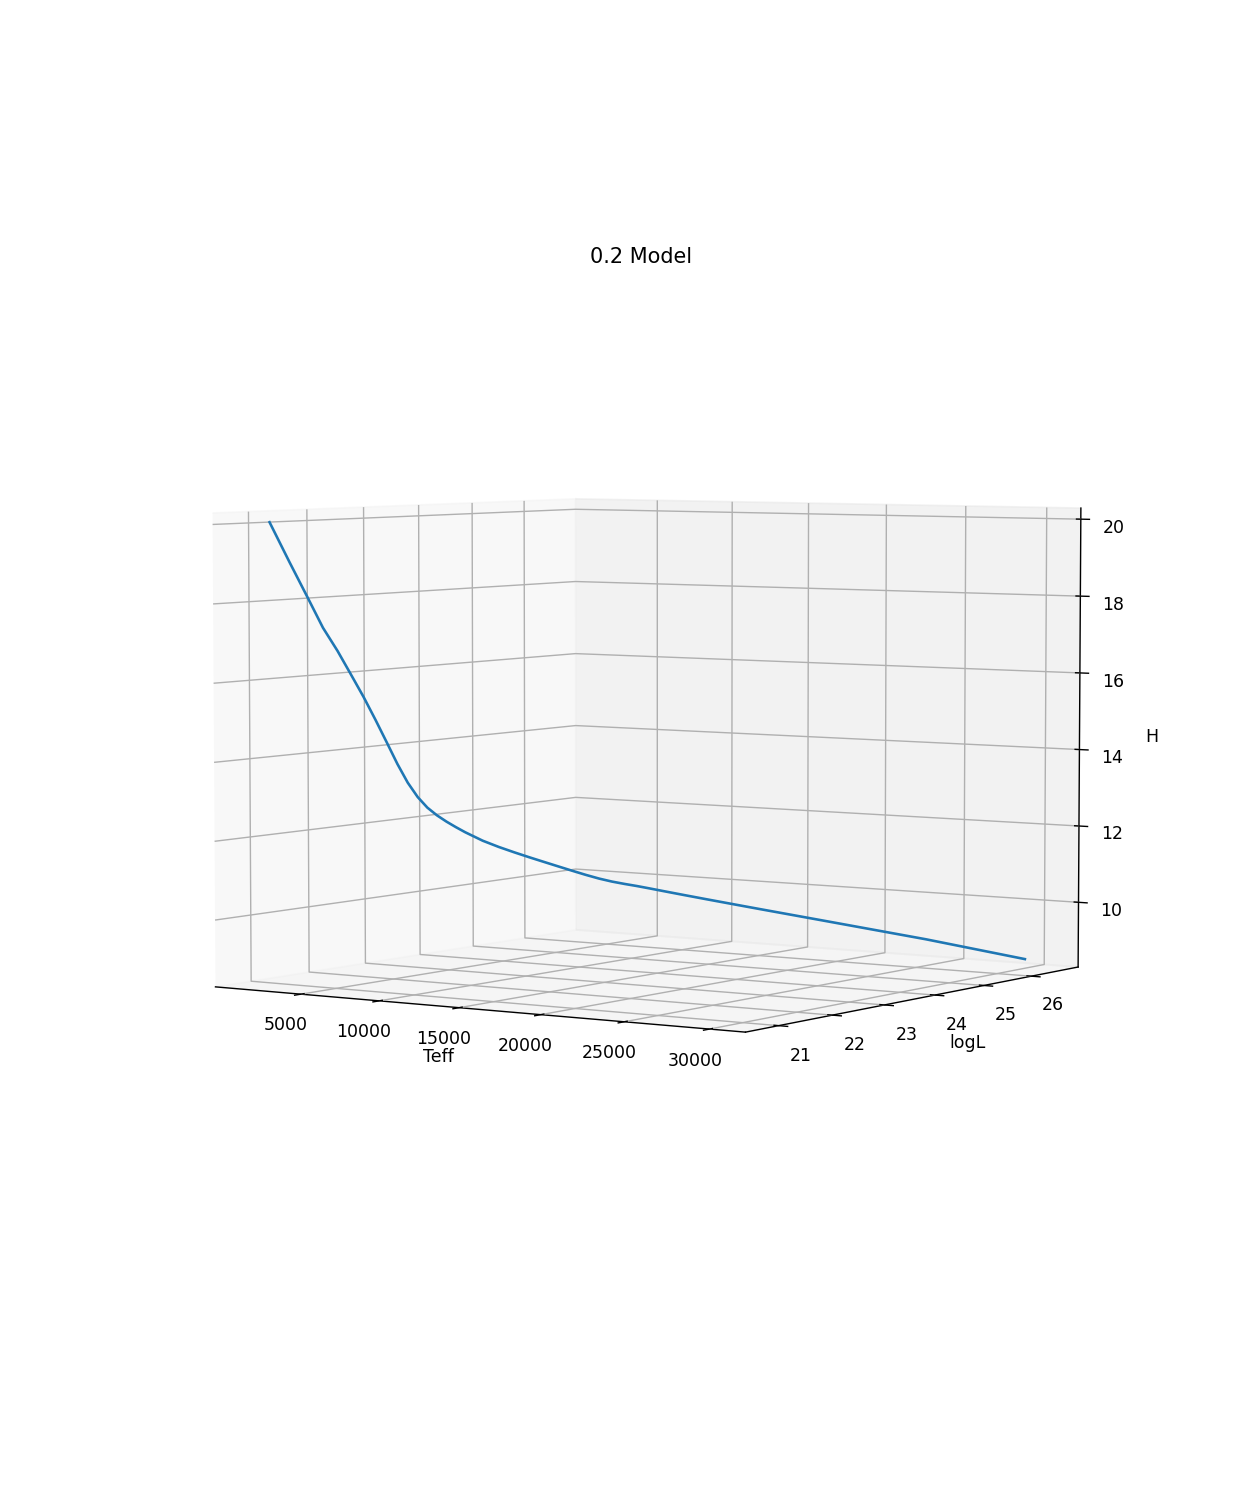

<IPython.core.display.Javascript object>


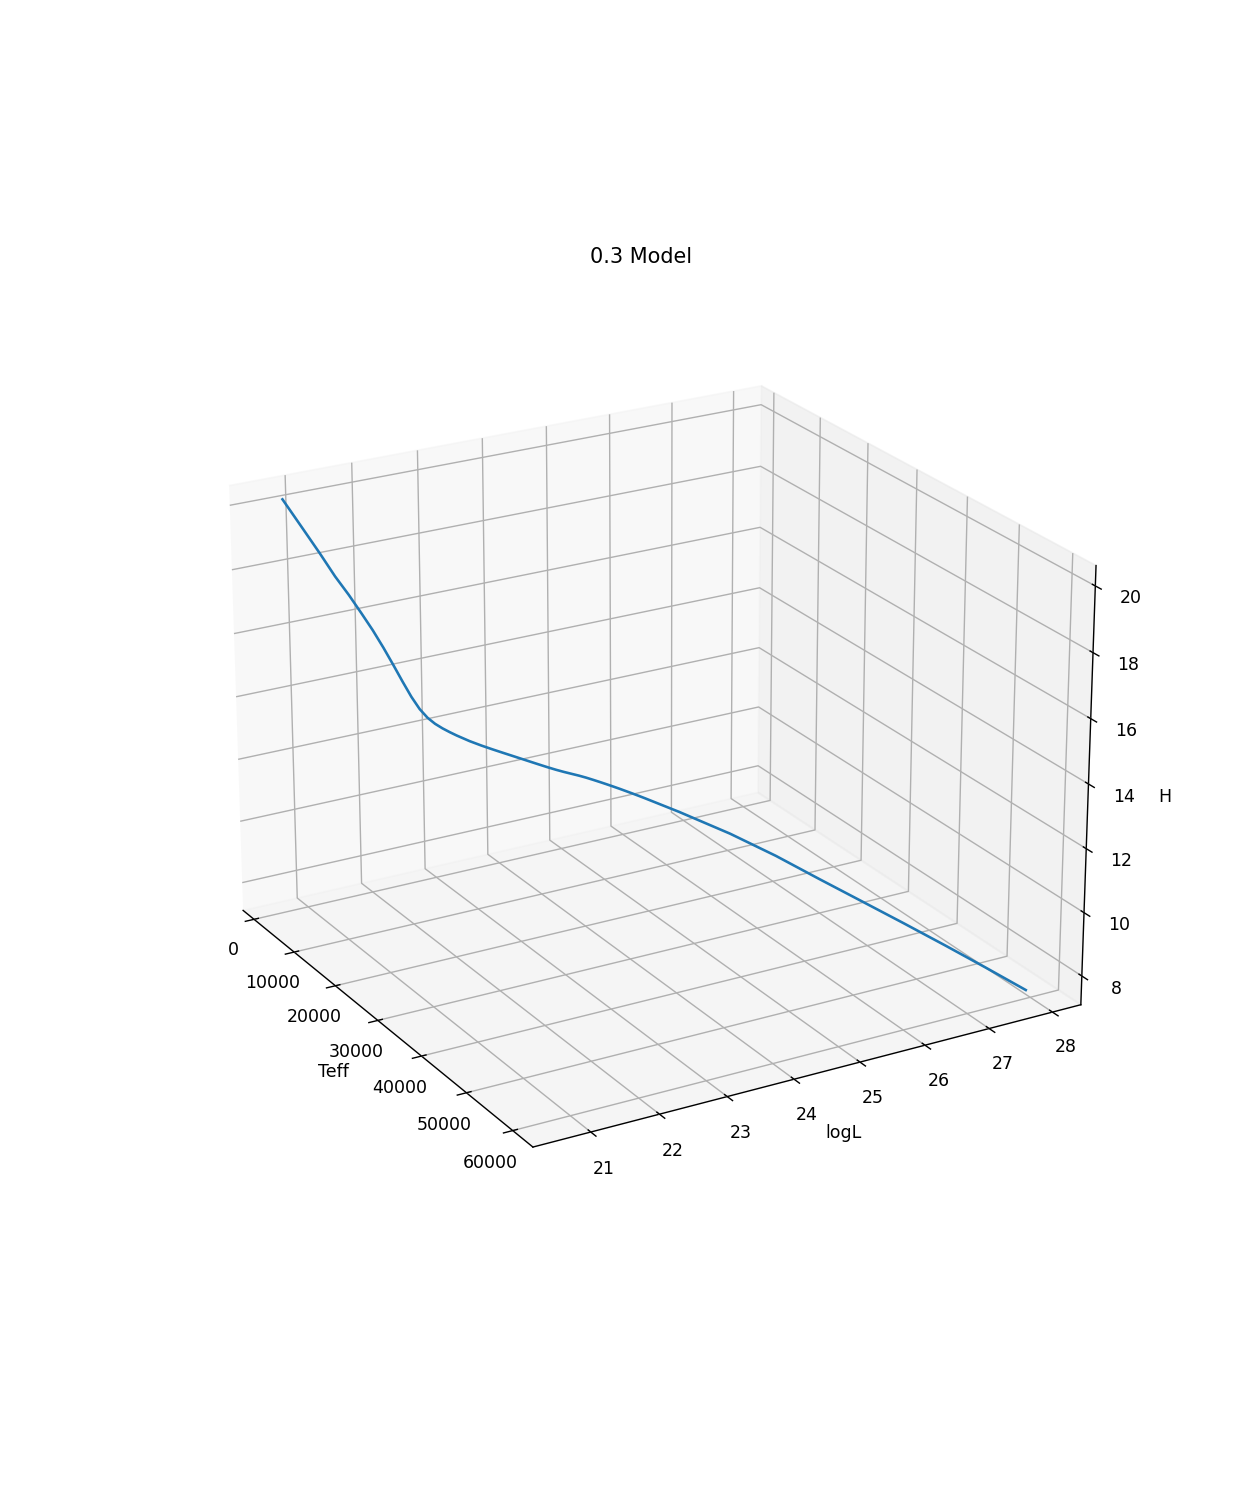

<IPython.core.display.Javascript object>


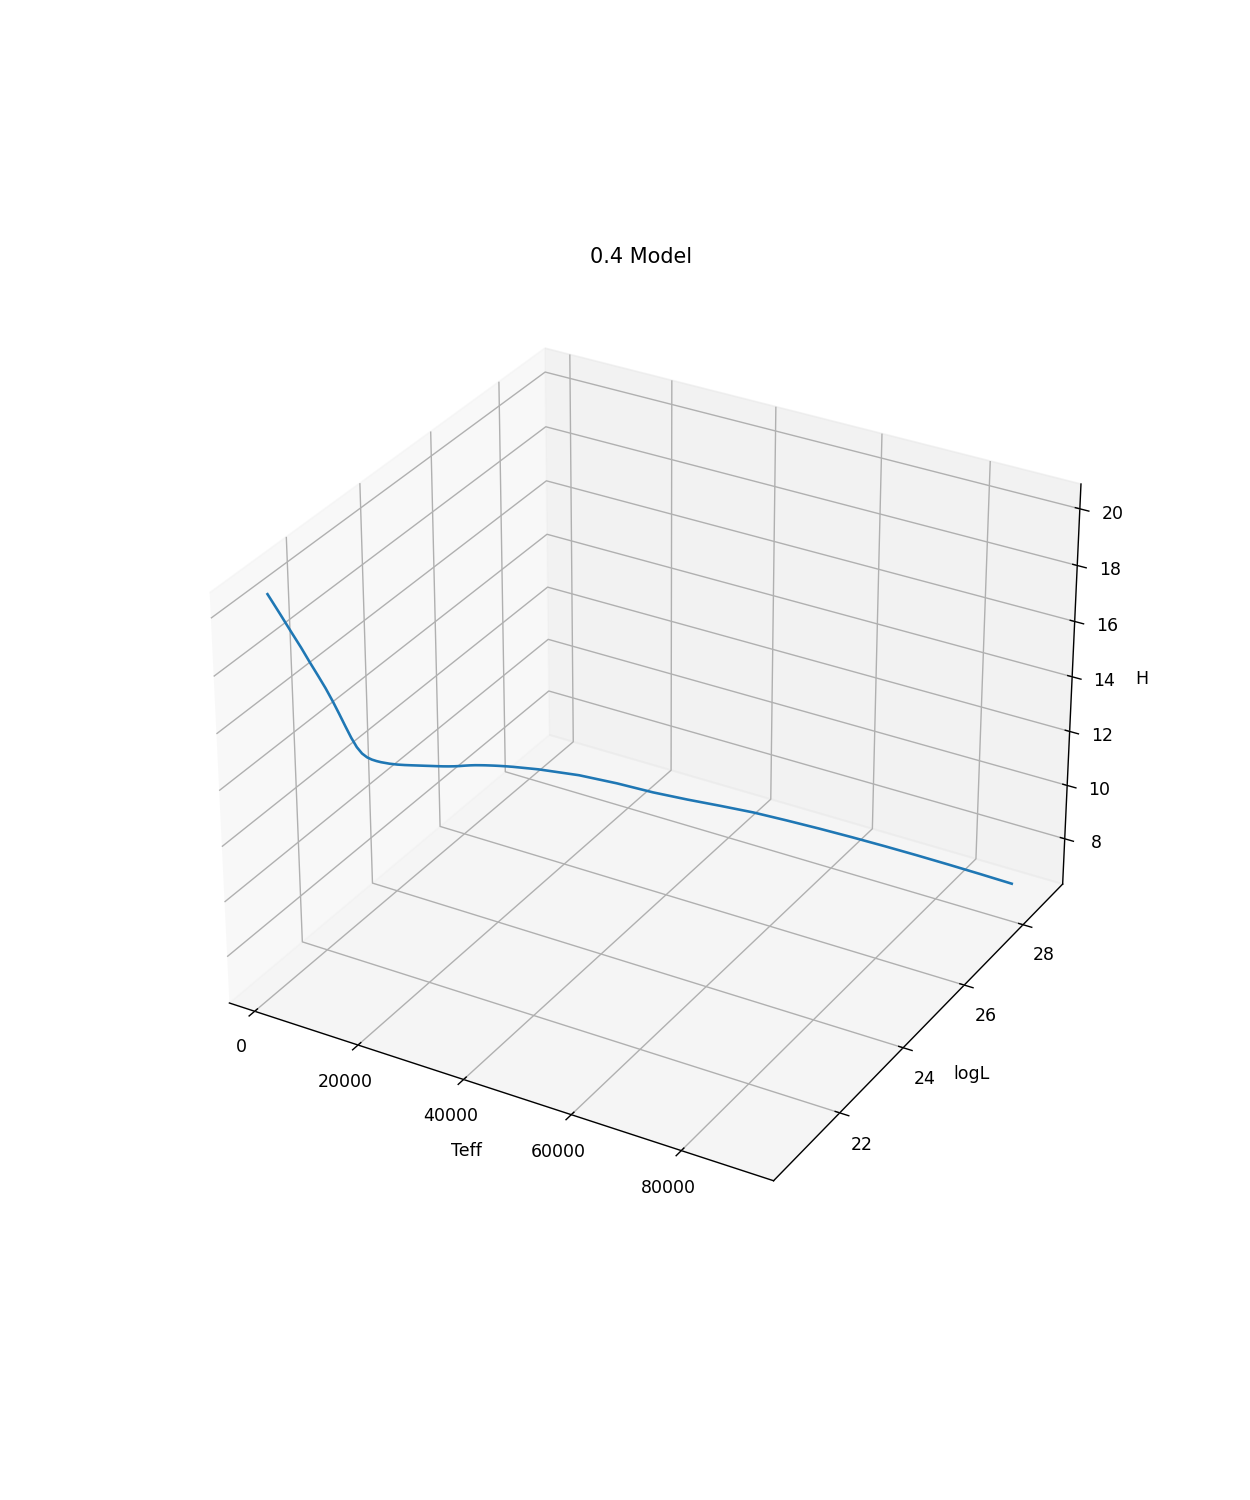

<IPython.core.display.Javascript object>


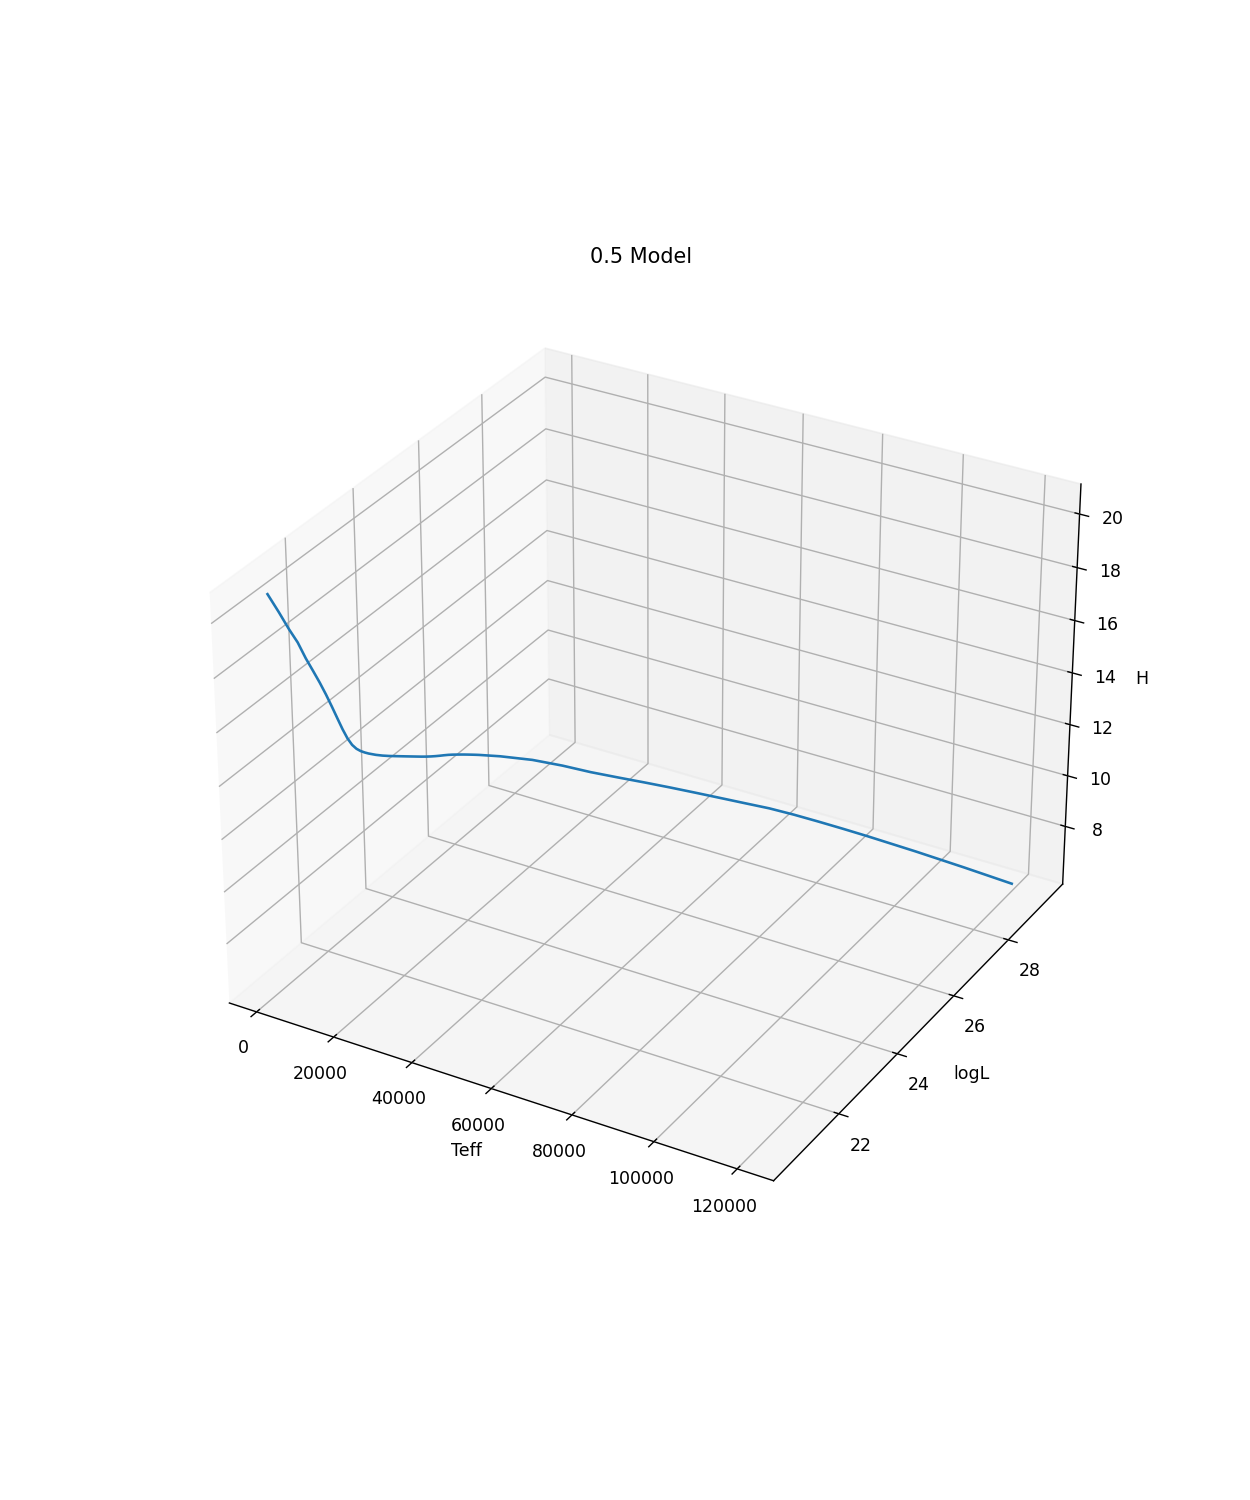

<IPython.core.display.Javascript object>


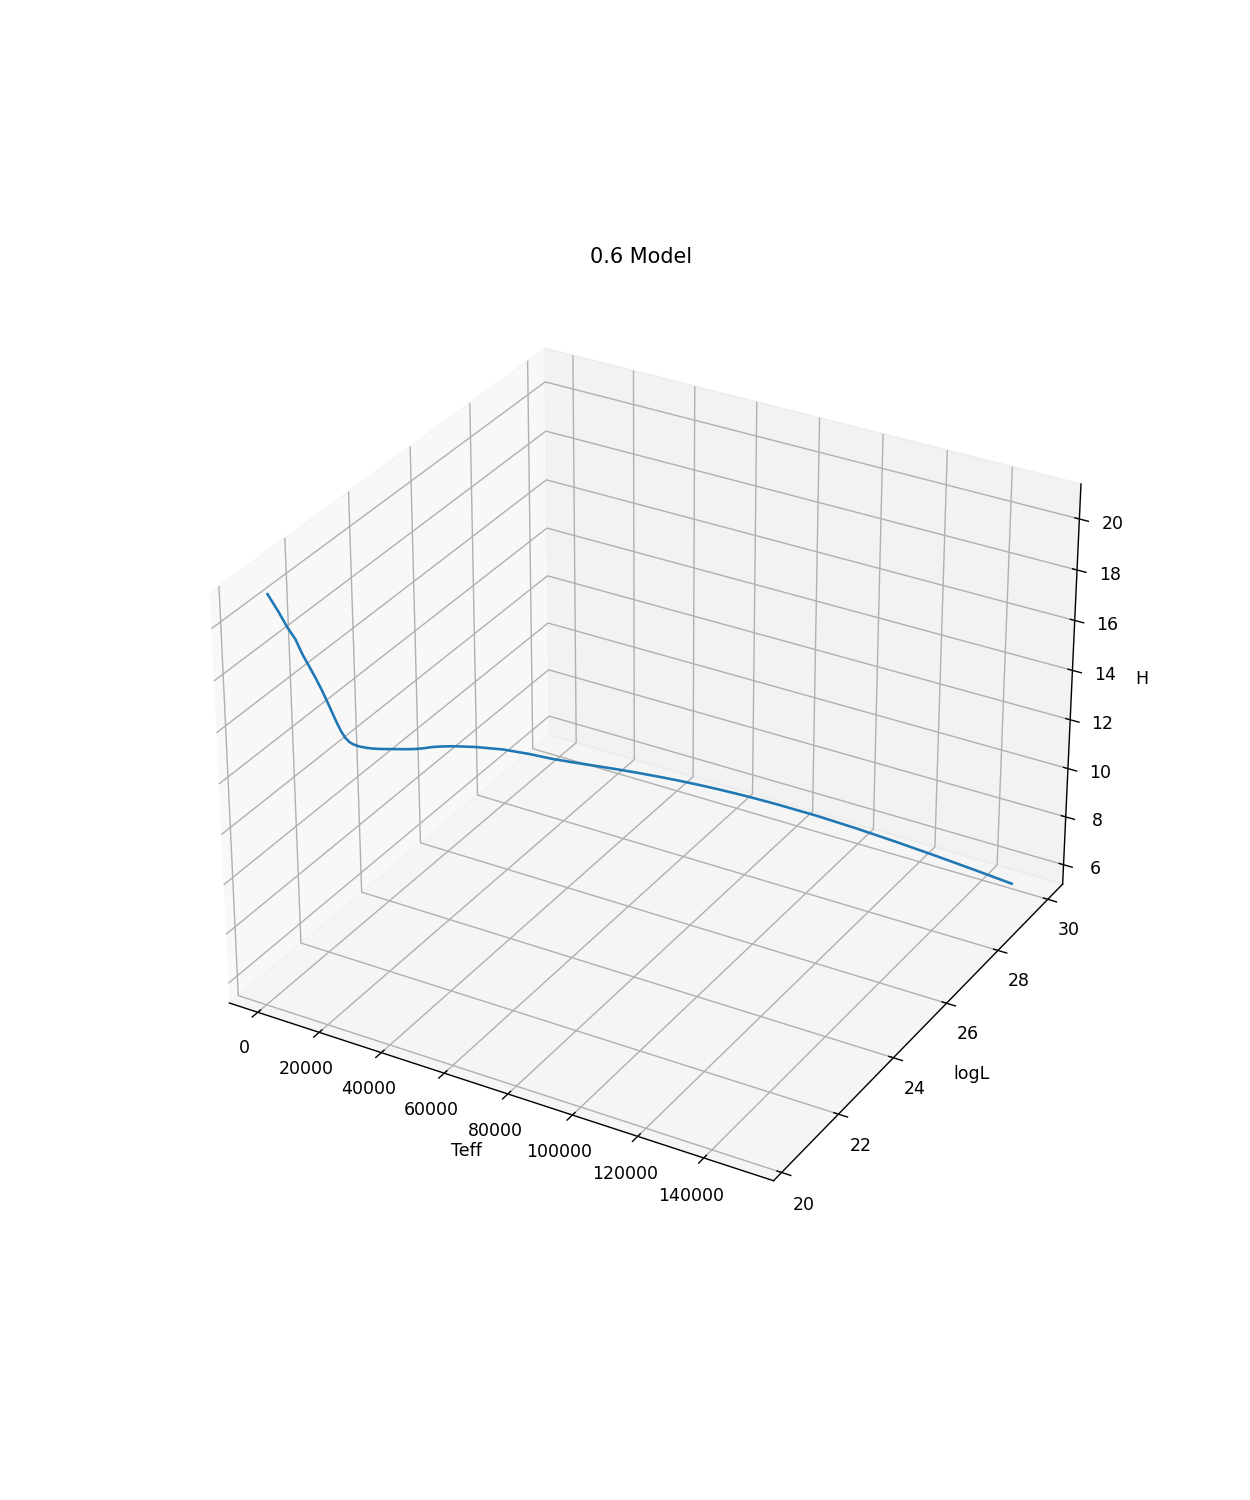

<IPython.core.display.Javascript object>


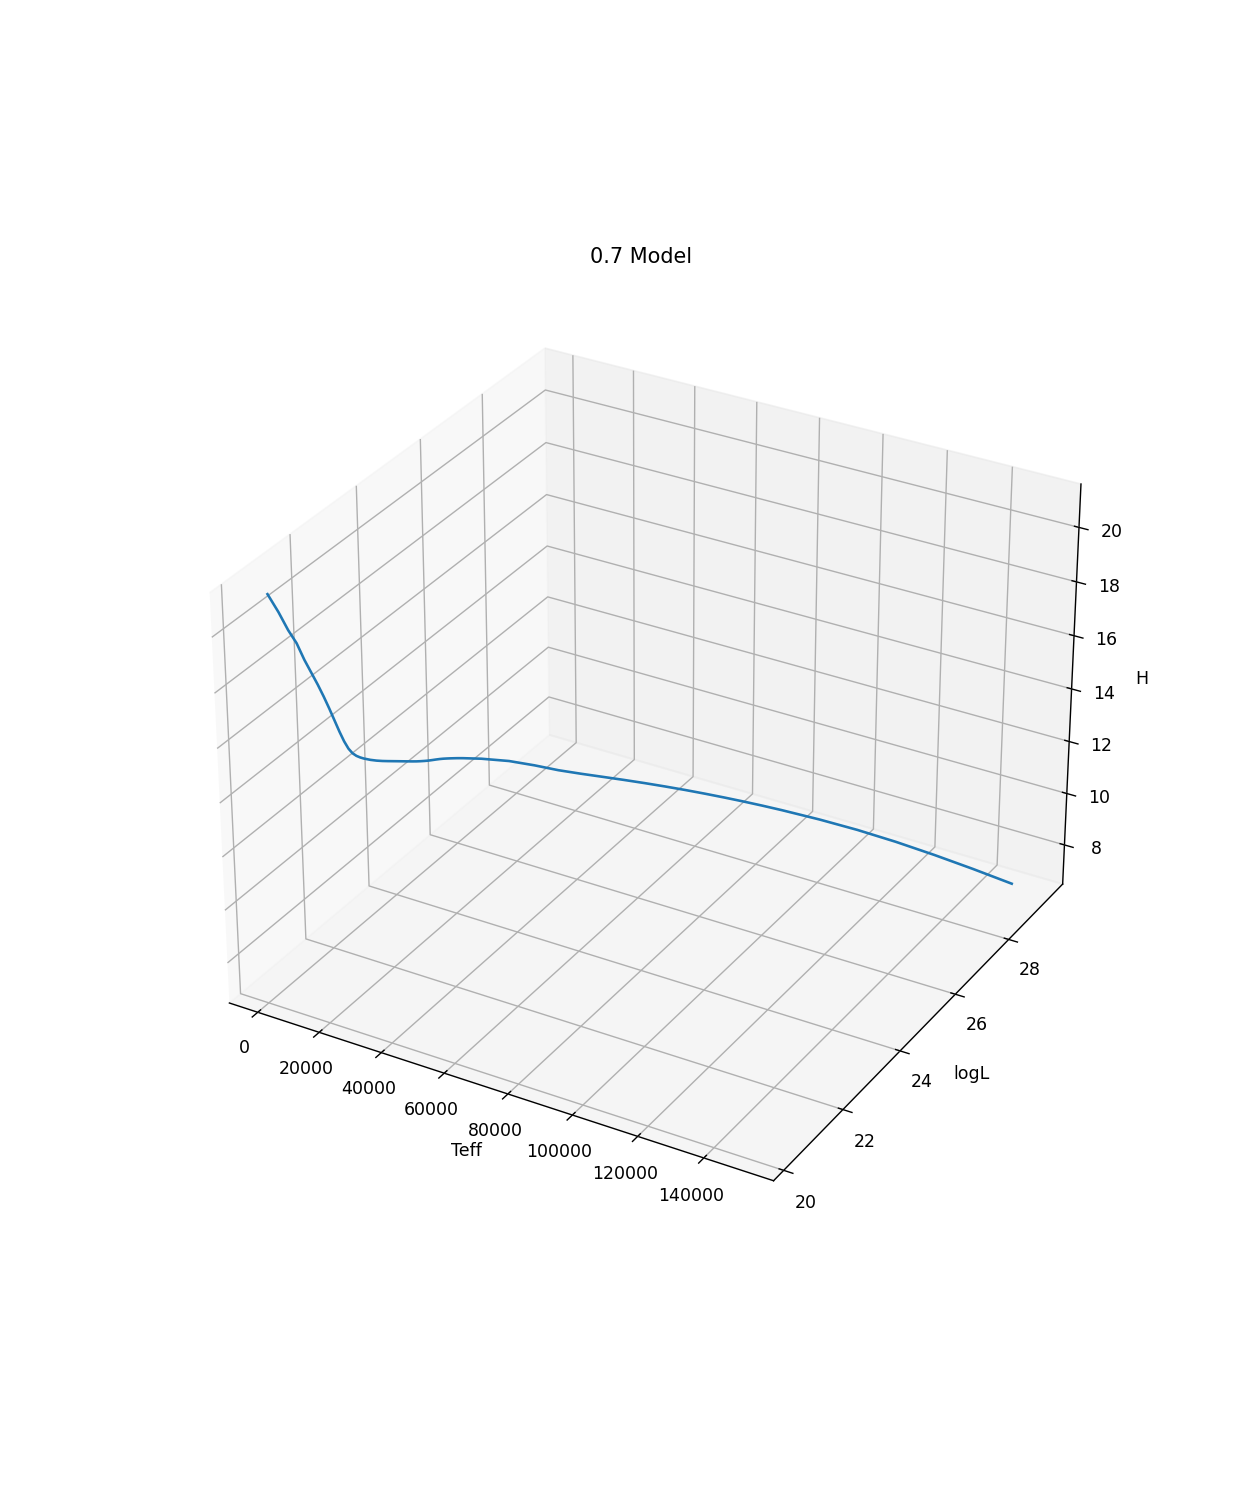

<IPython.core.display.Javascript object>


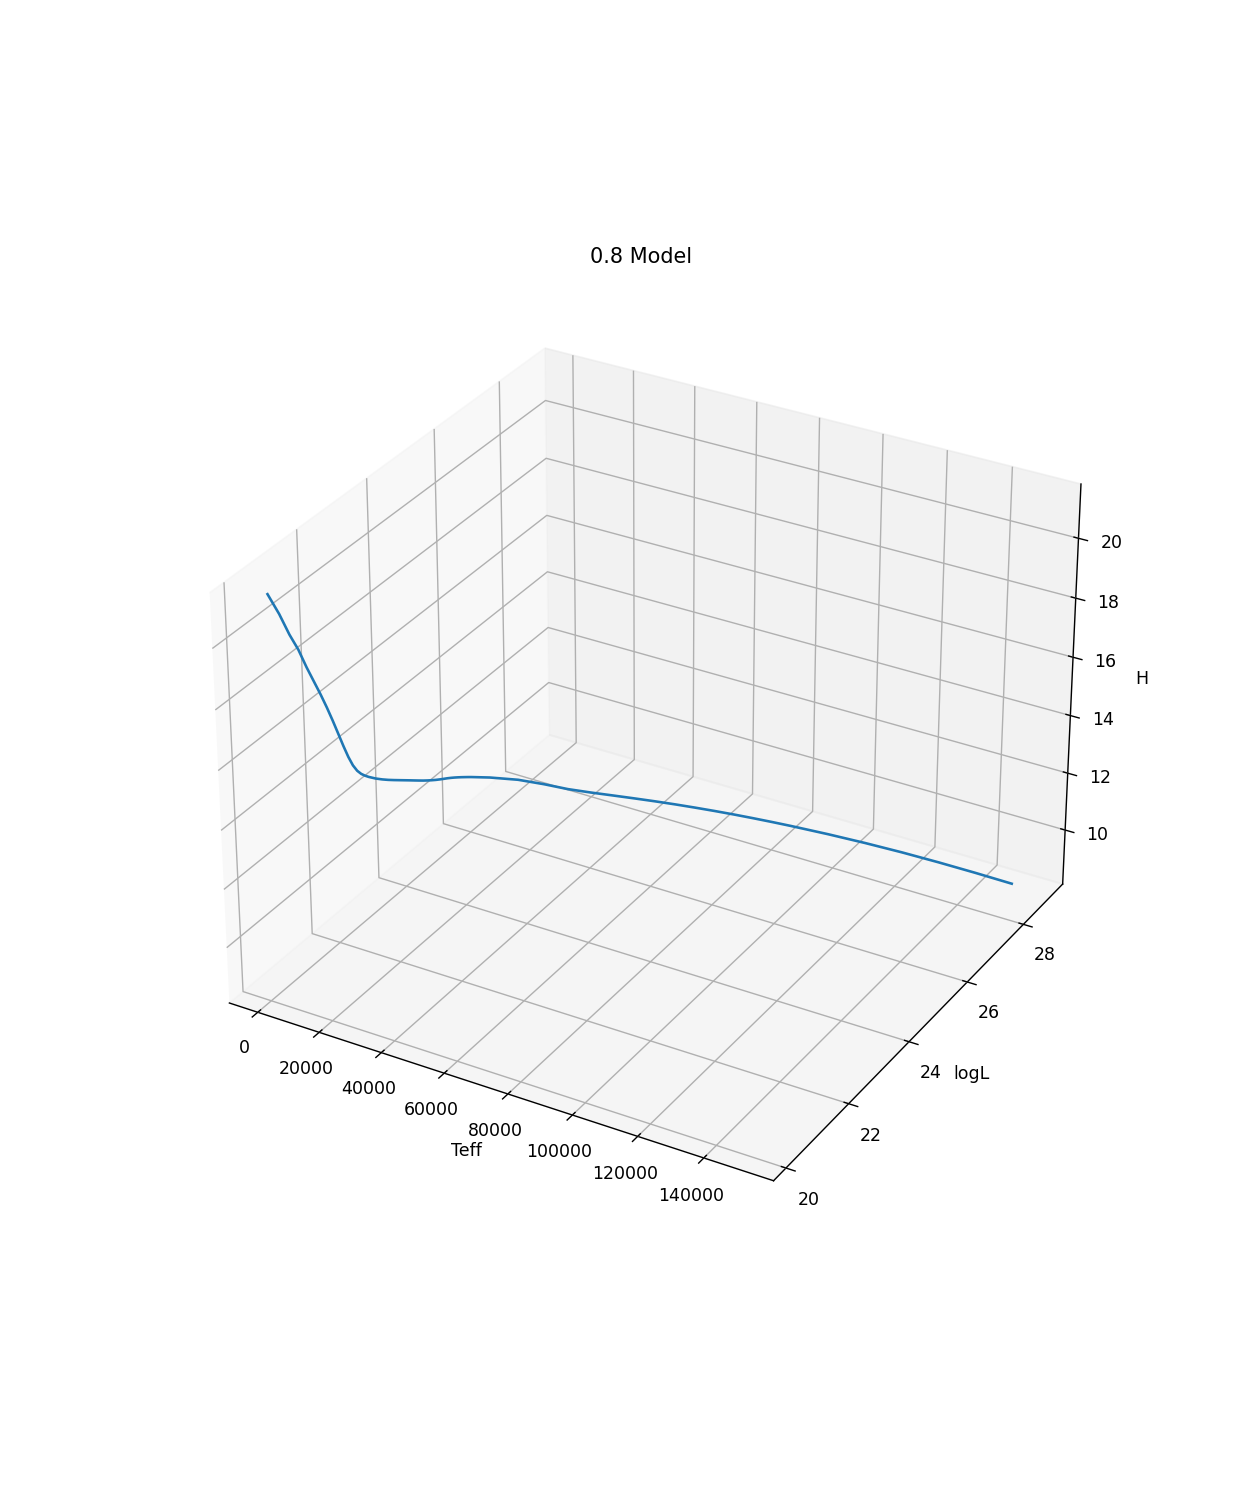

<IPython.core.display.Javascript object>


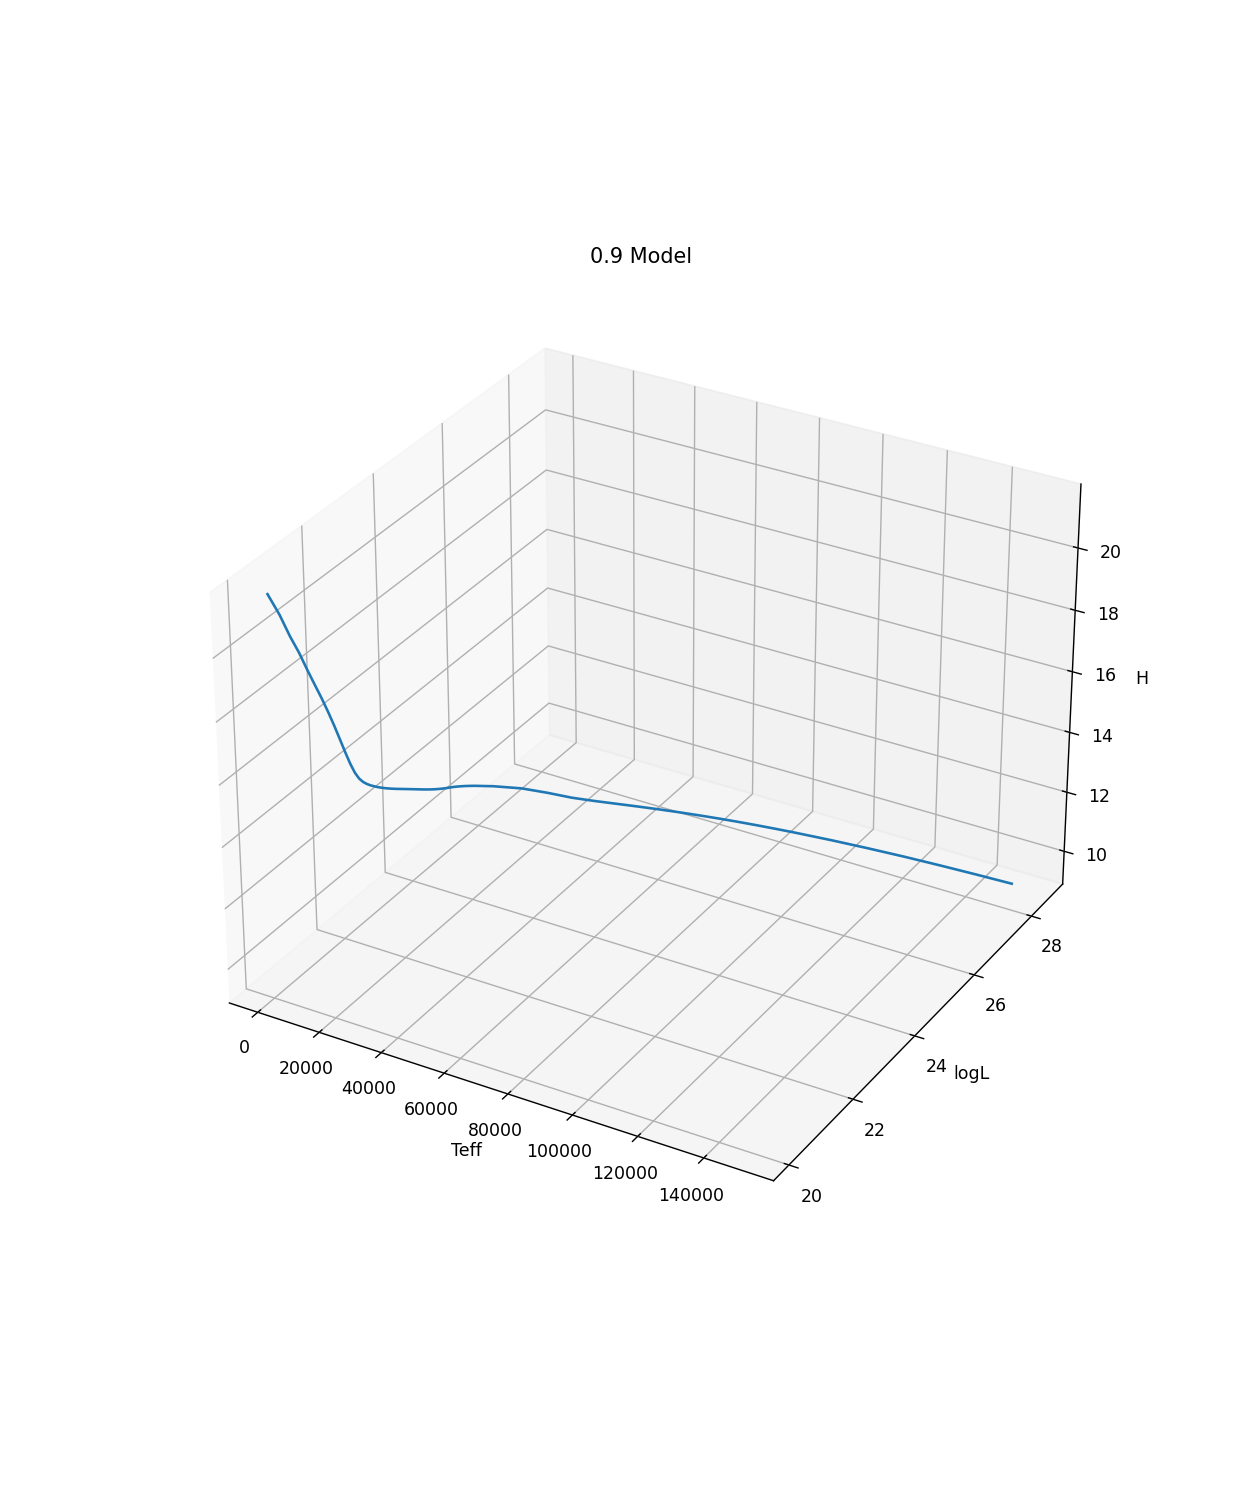

<IPython.core.display.Javascript object>


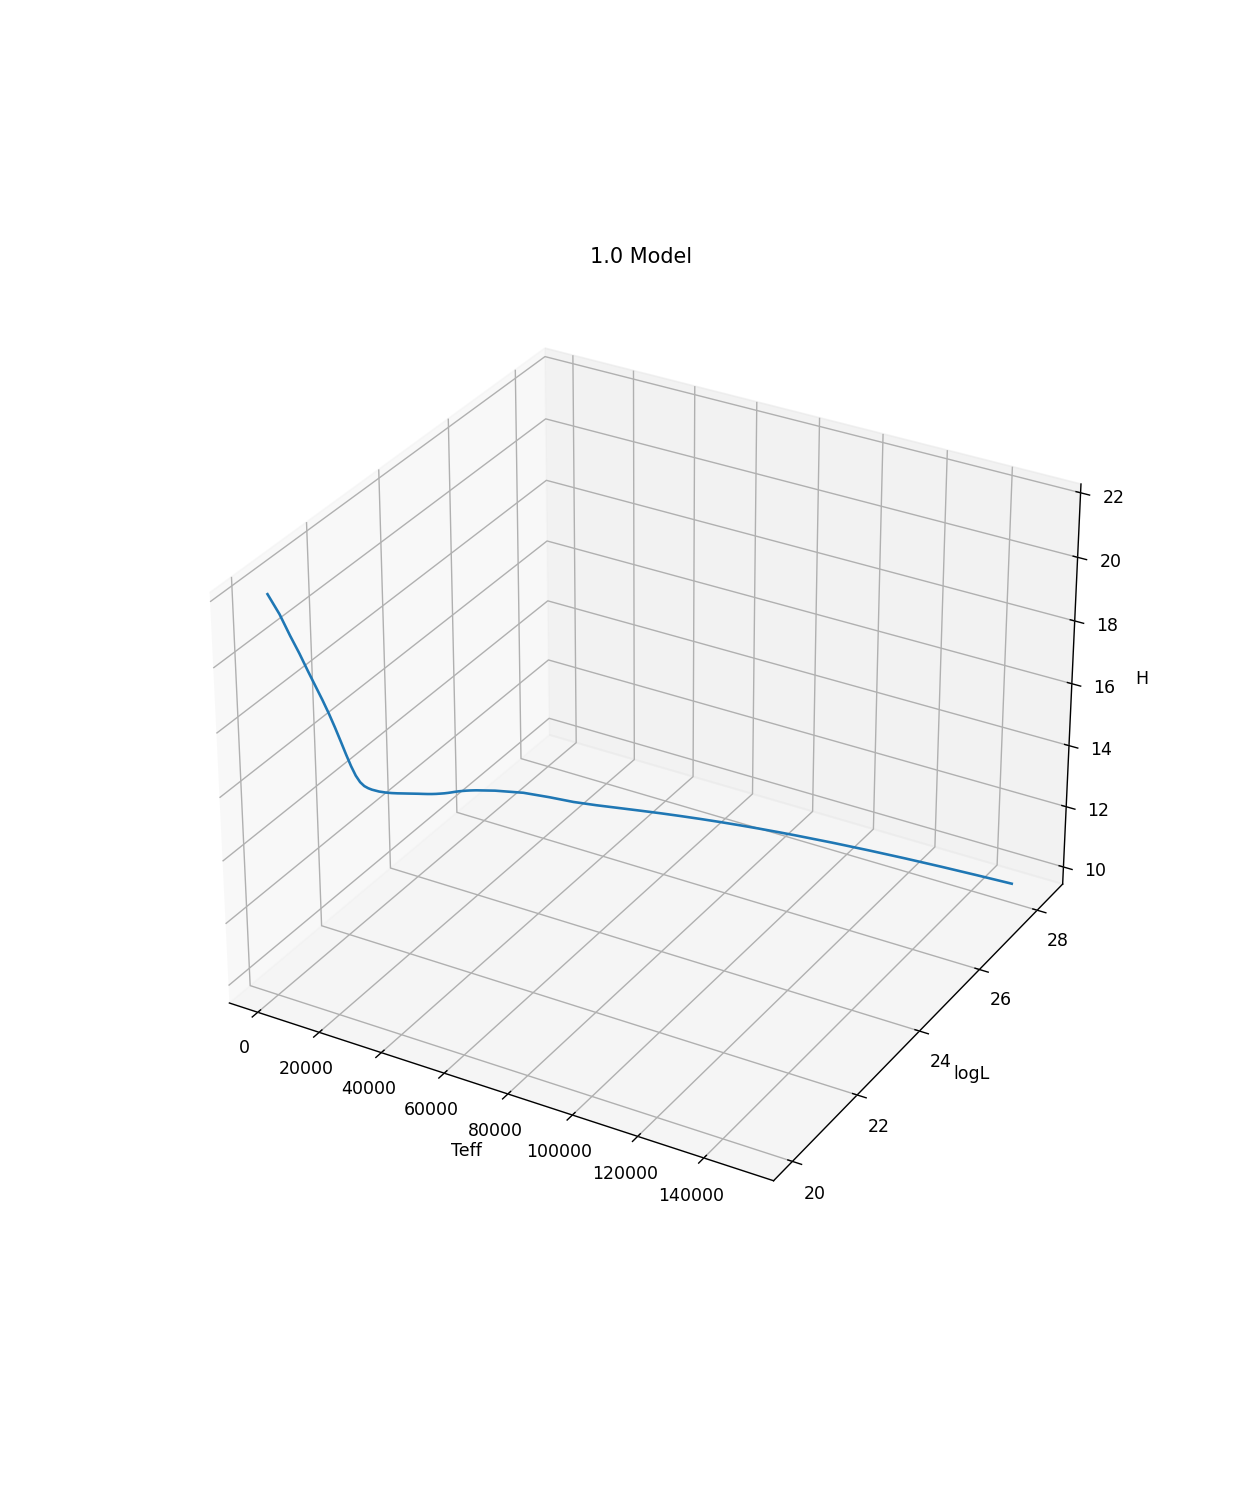

<IPython.core.display.Javascript object>


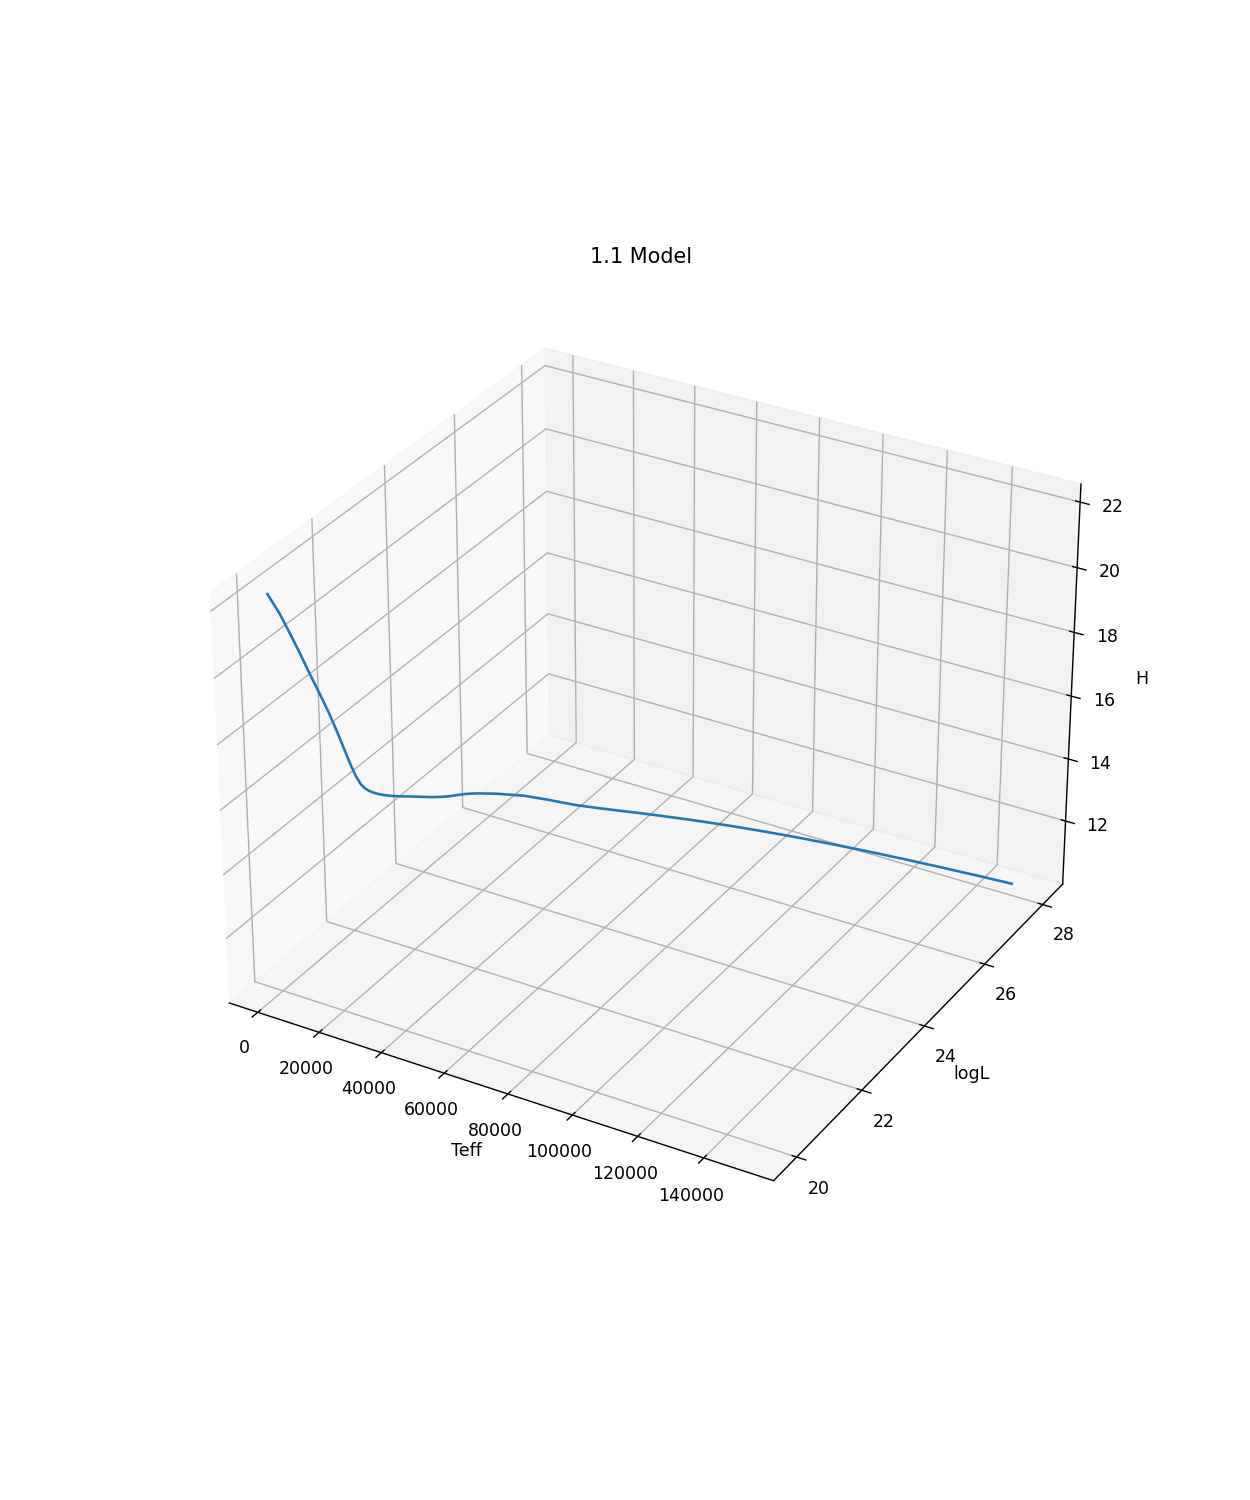

In [ ]:
plotter3D("Teff", "logL", "H")

<IPython.core.display.Javascript object>


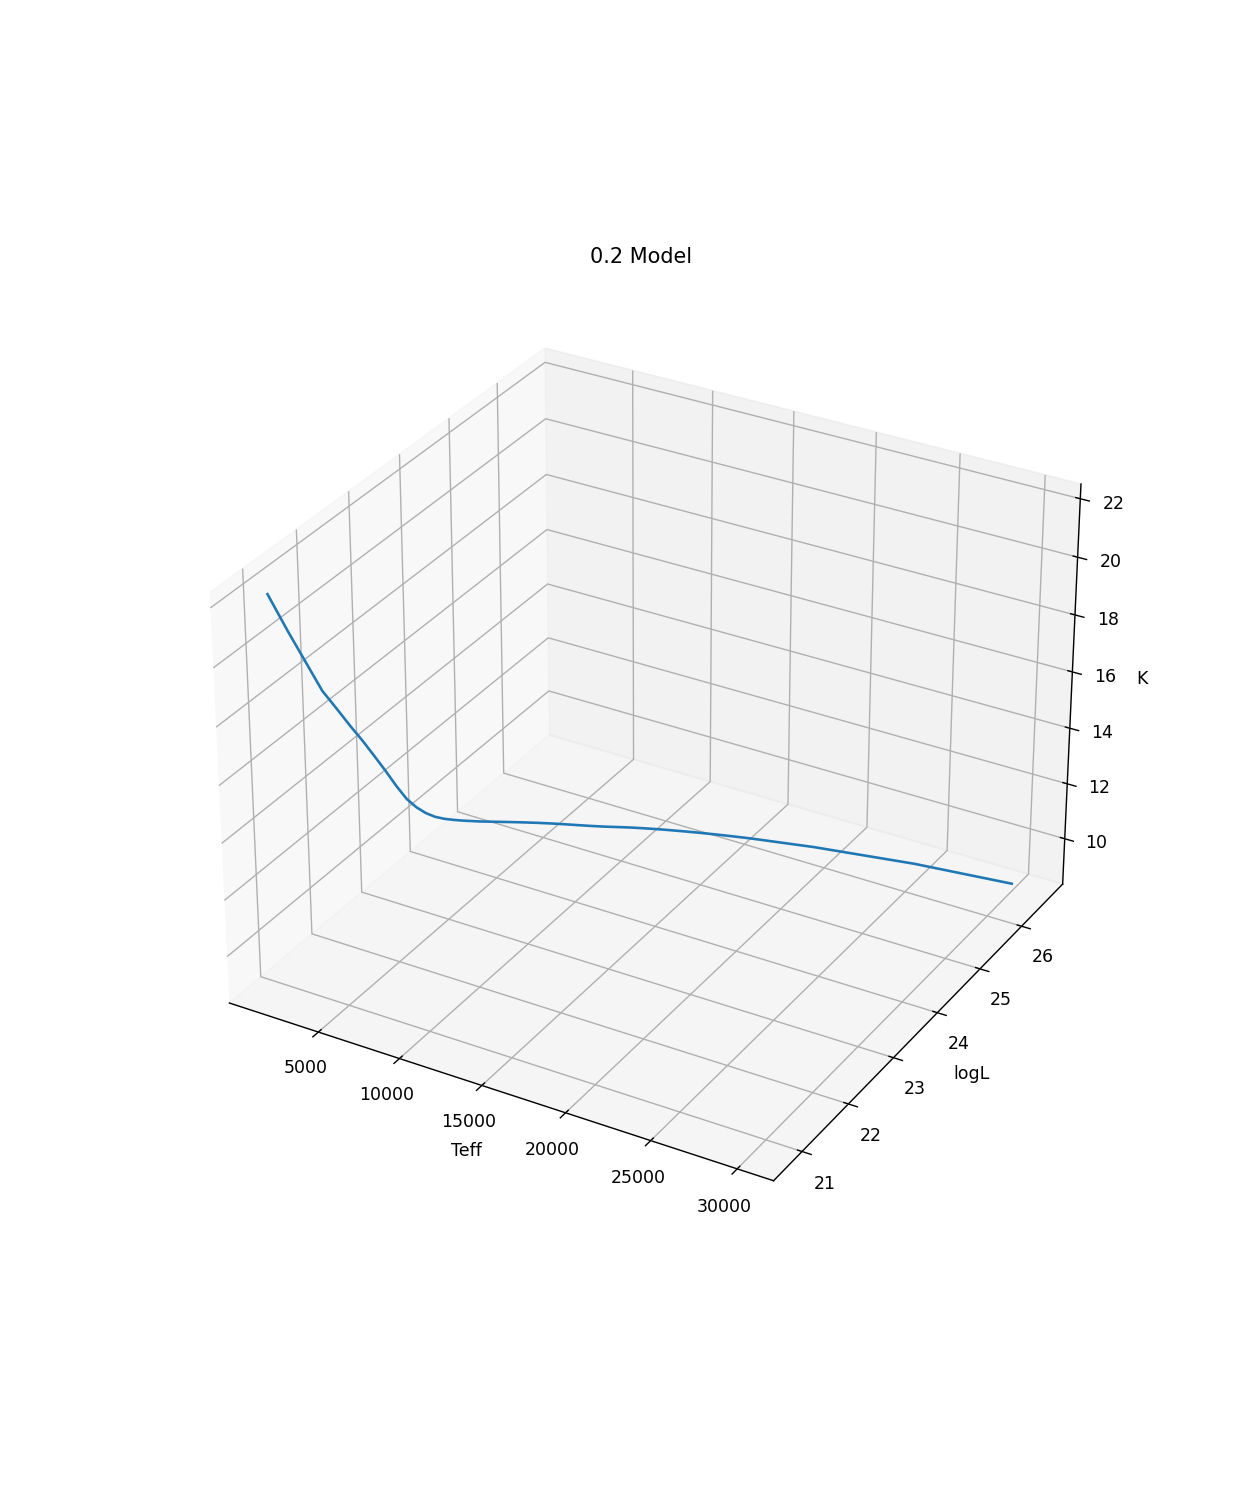

<IPython.core.display.Javascript object>


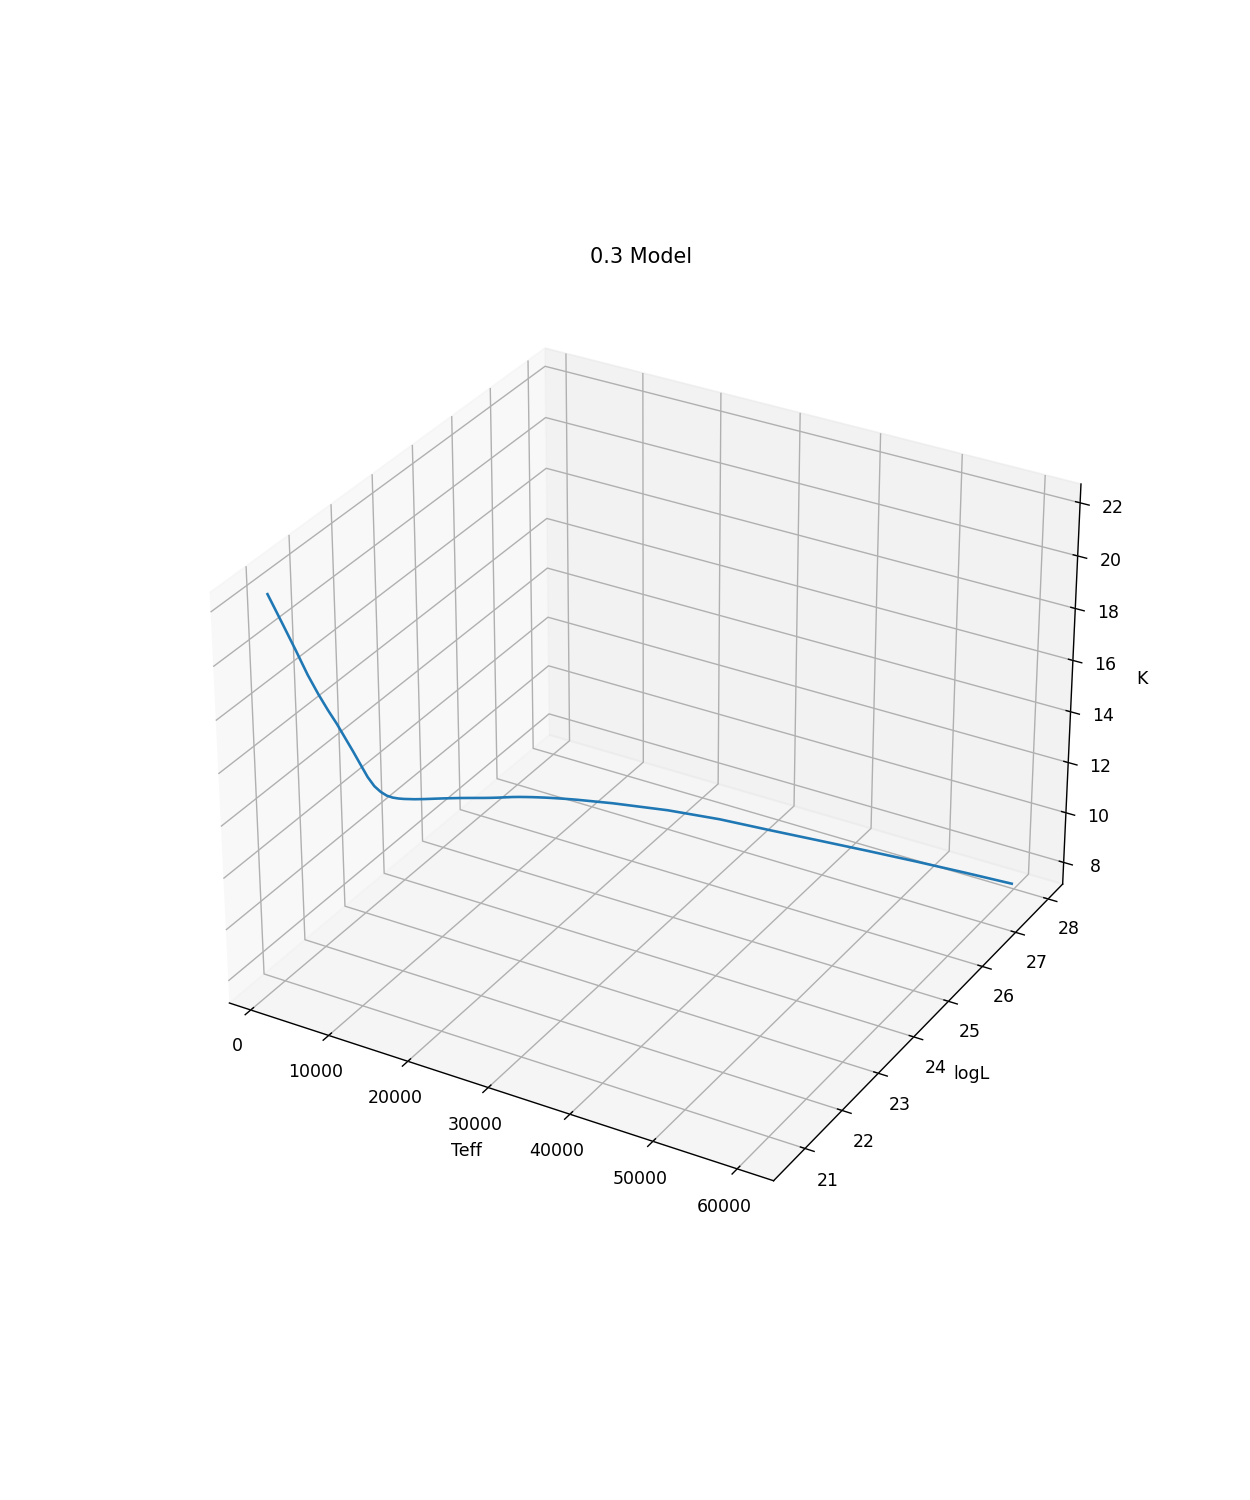

<IPython.core.display.Javascript object>


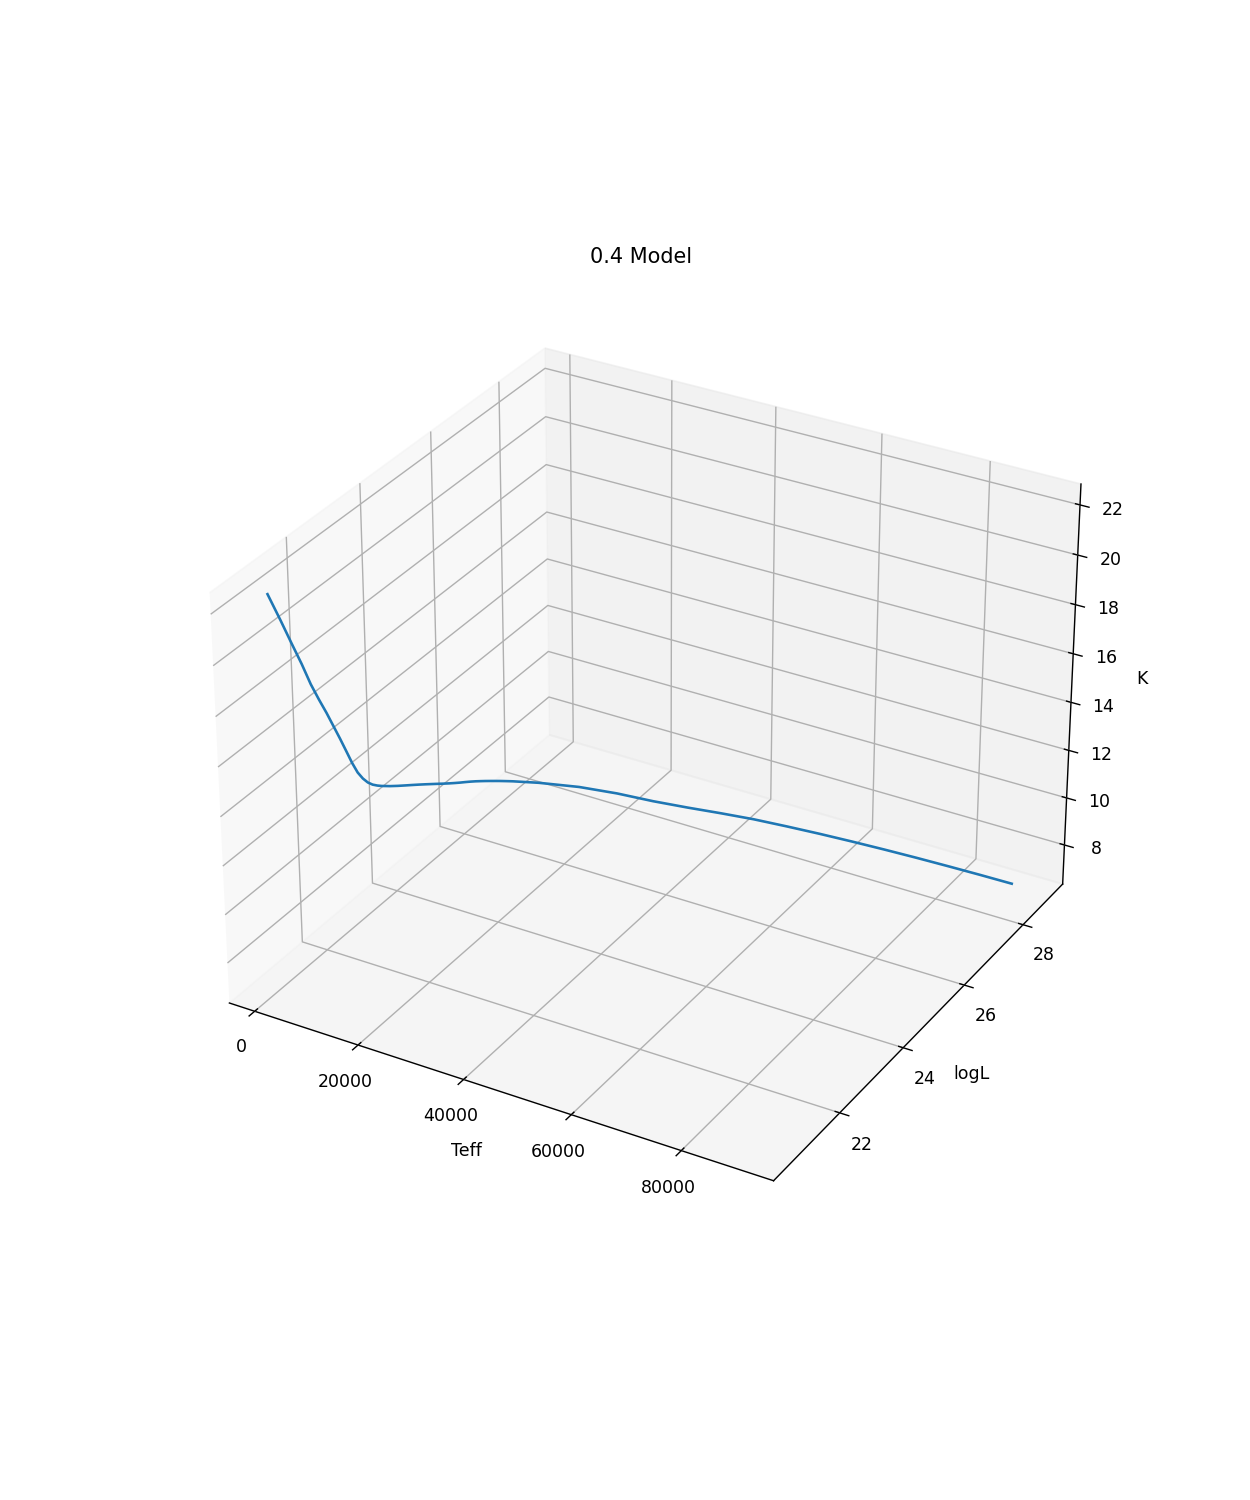

<IPython.core.display.Javascript object>


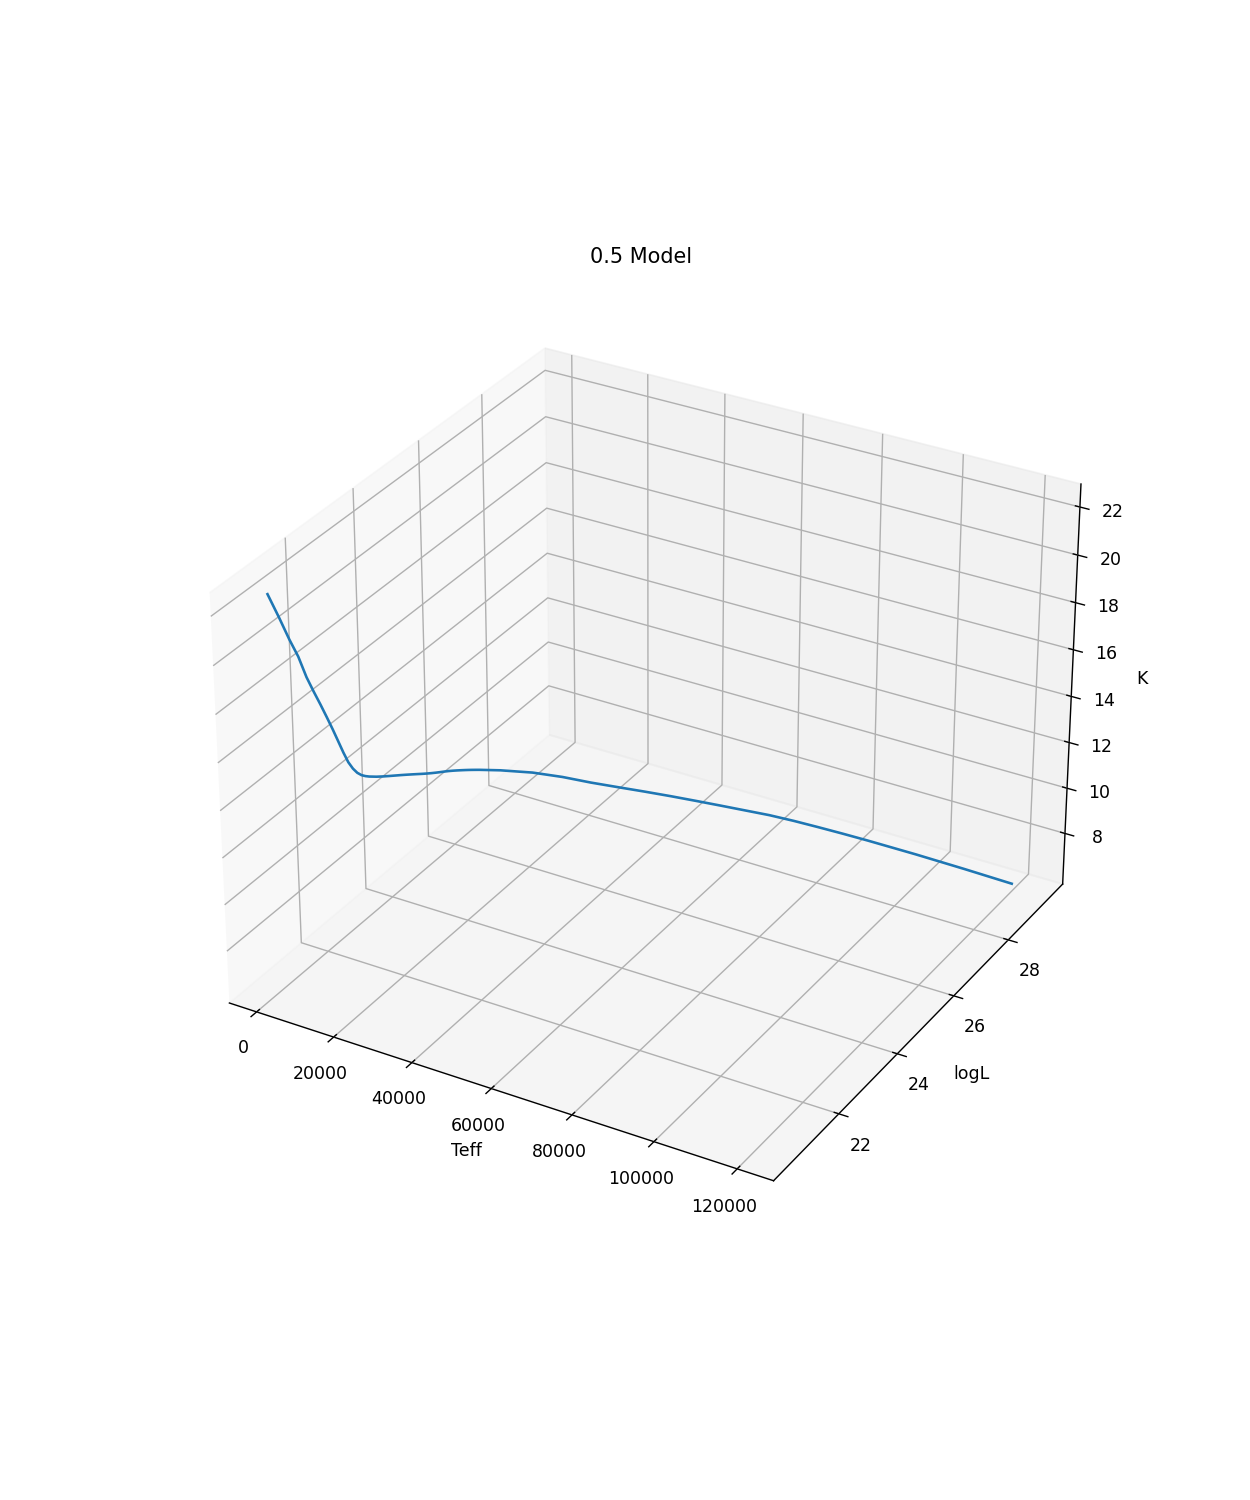

<IPython.core.display.Javascript object>


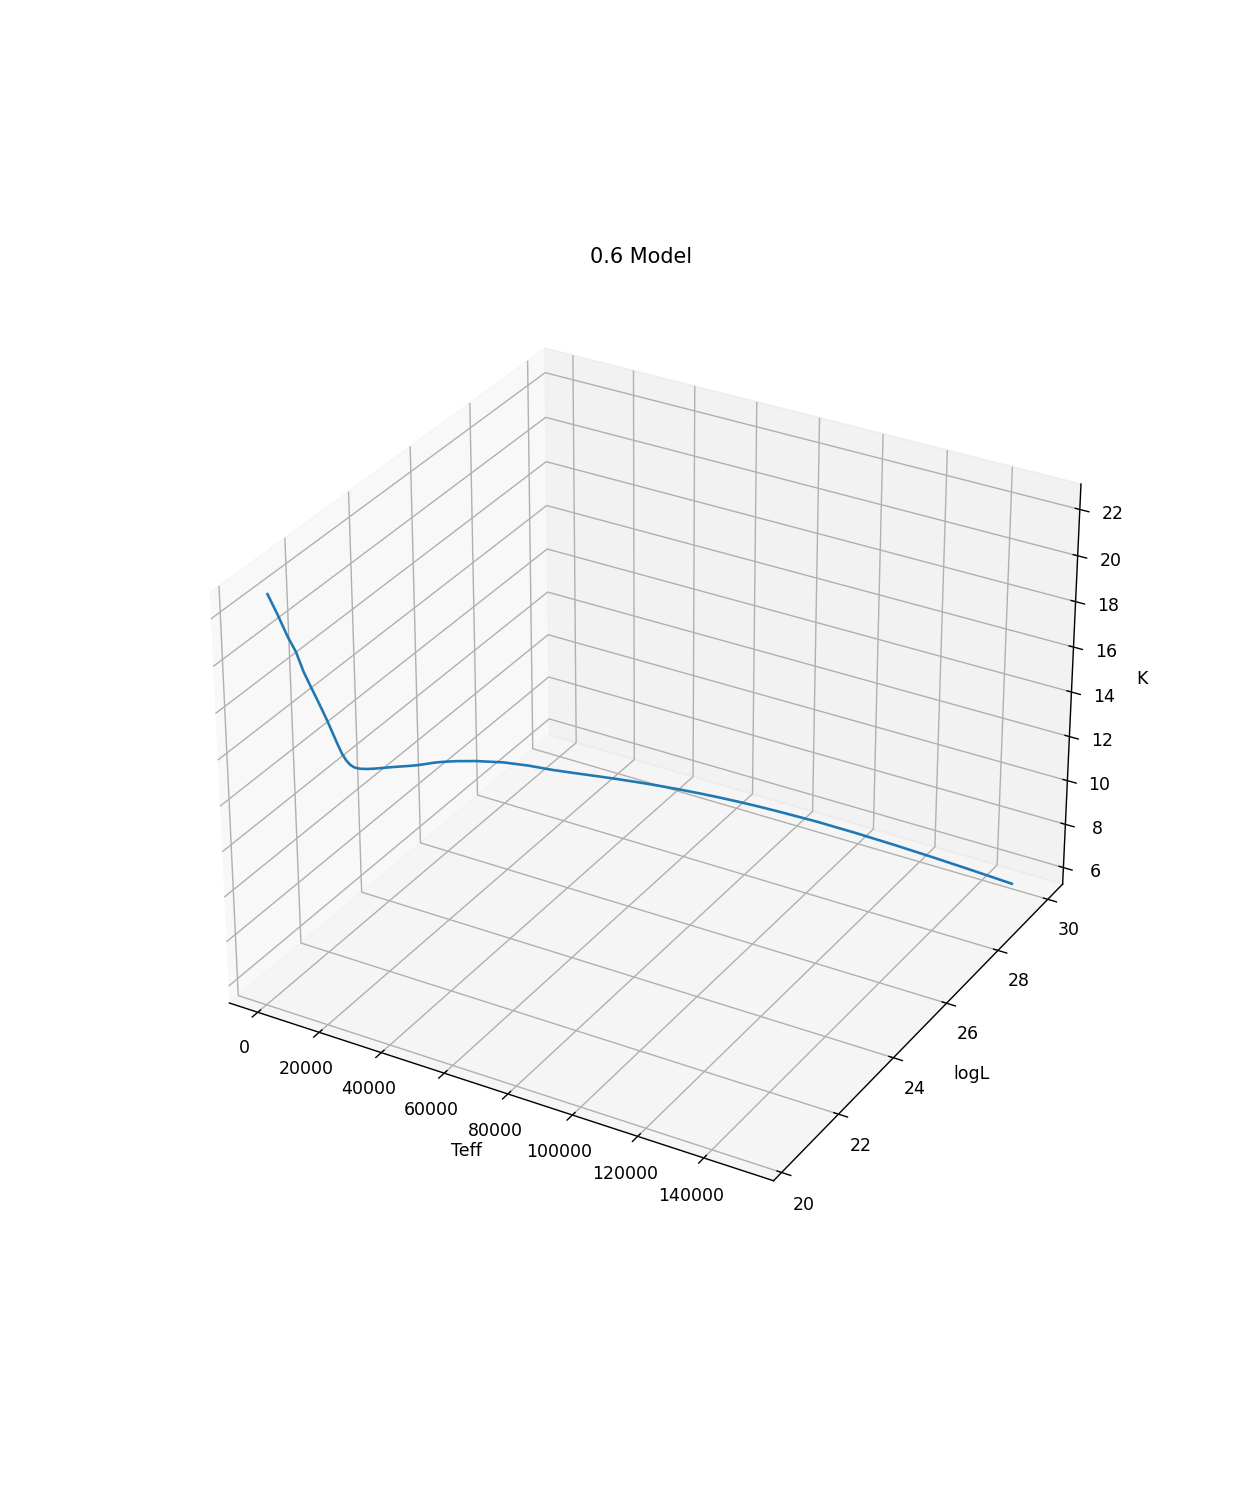

<IPython.core.display.Javascript object>


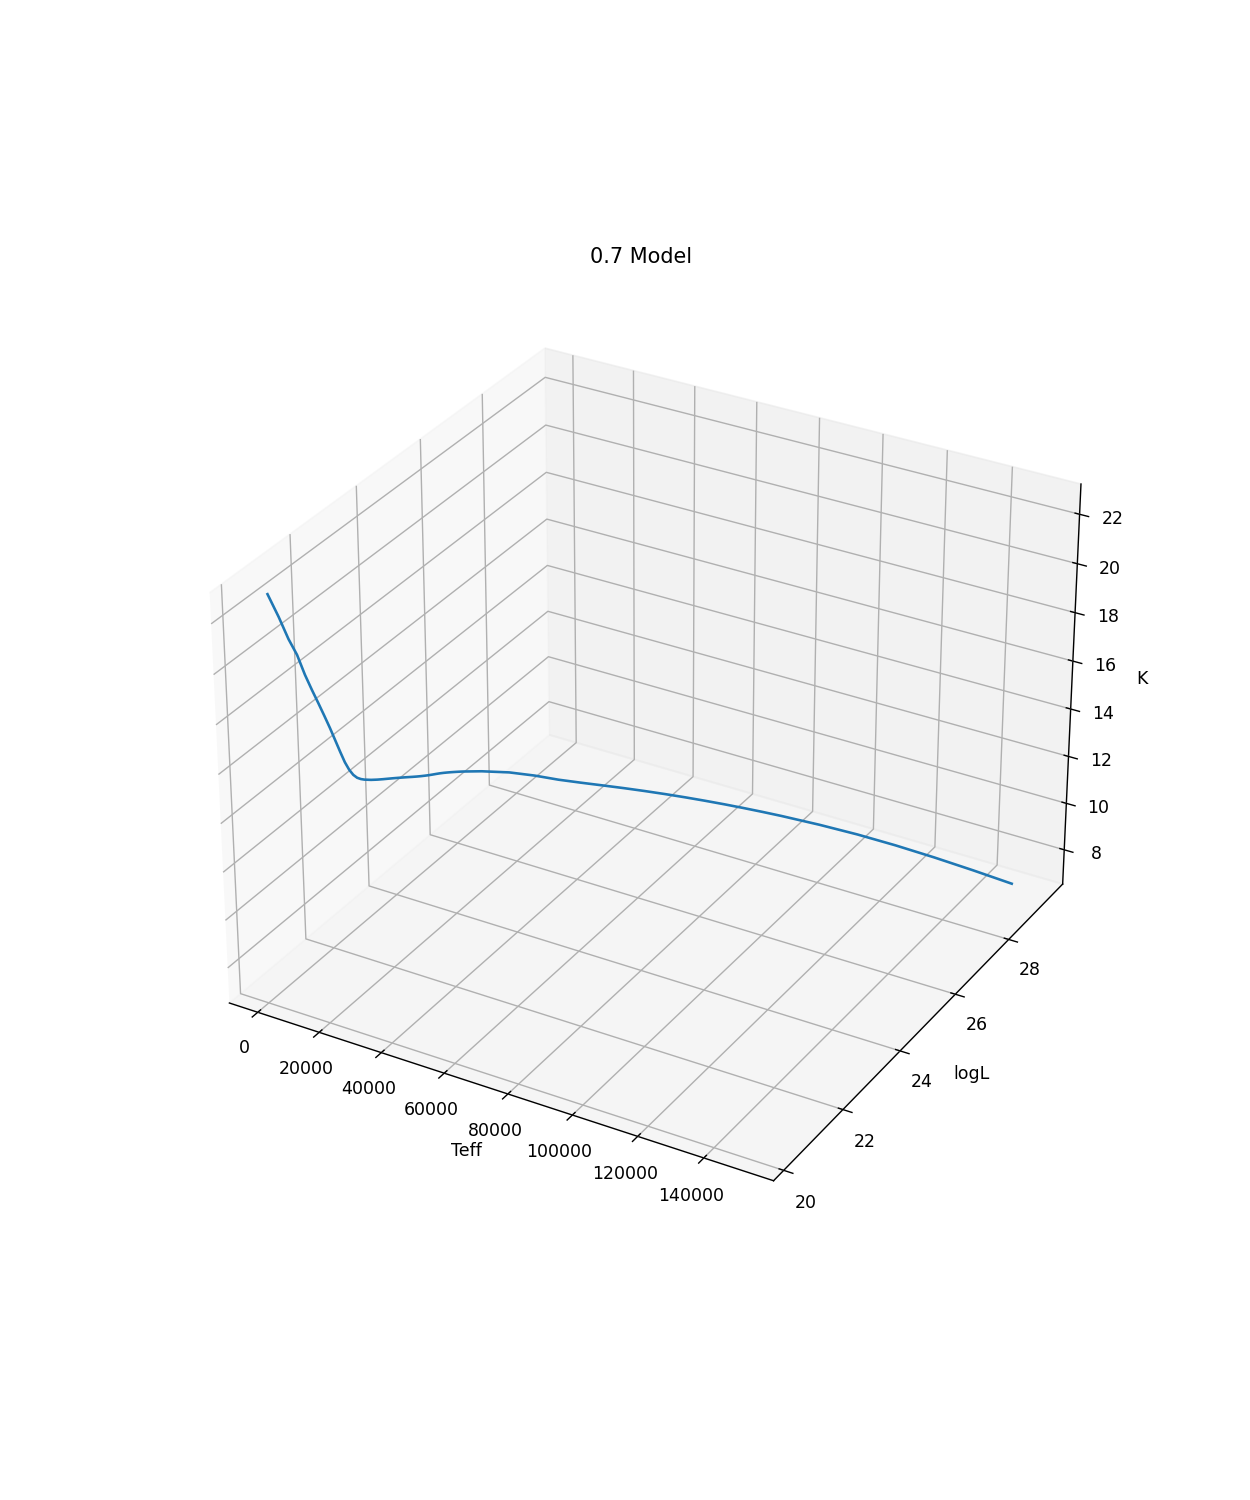

<IPython.core.display.Javascript object>


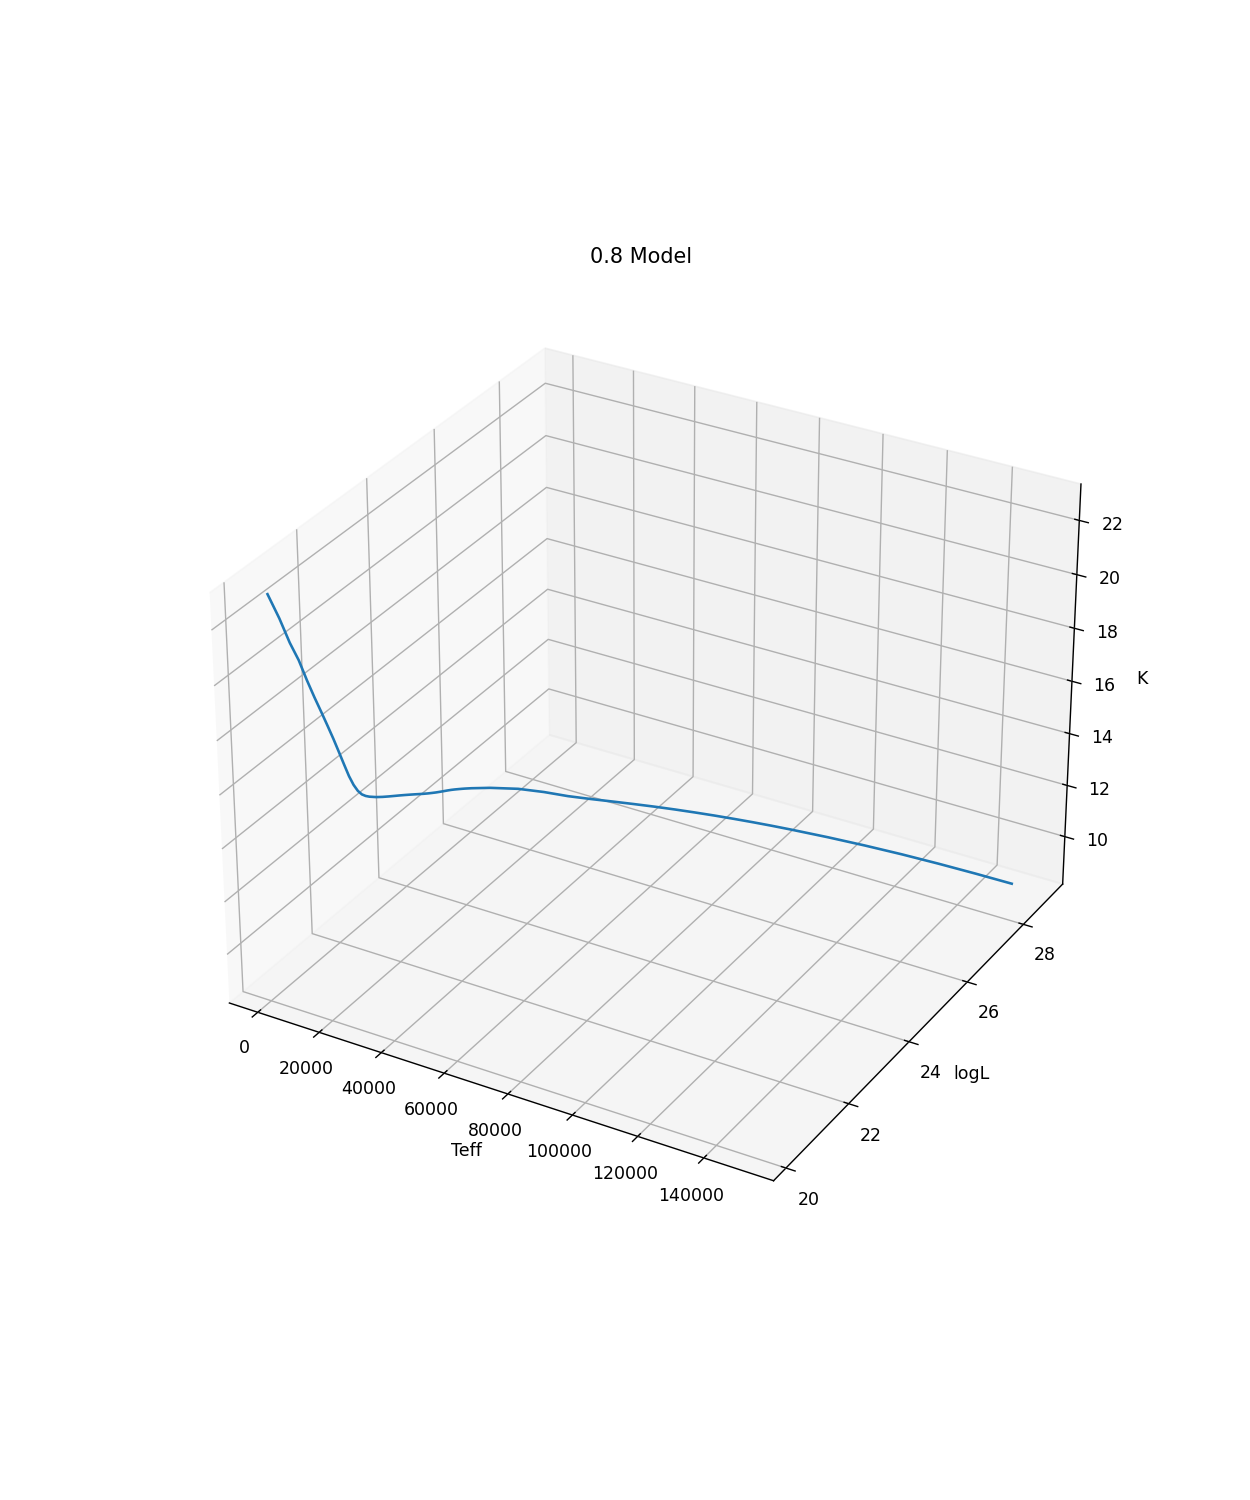

<IPython.core.display.Javascript object>


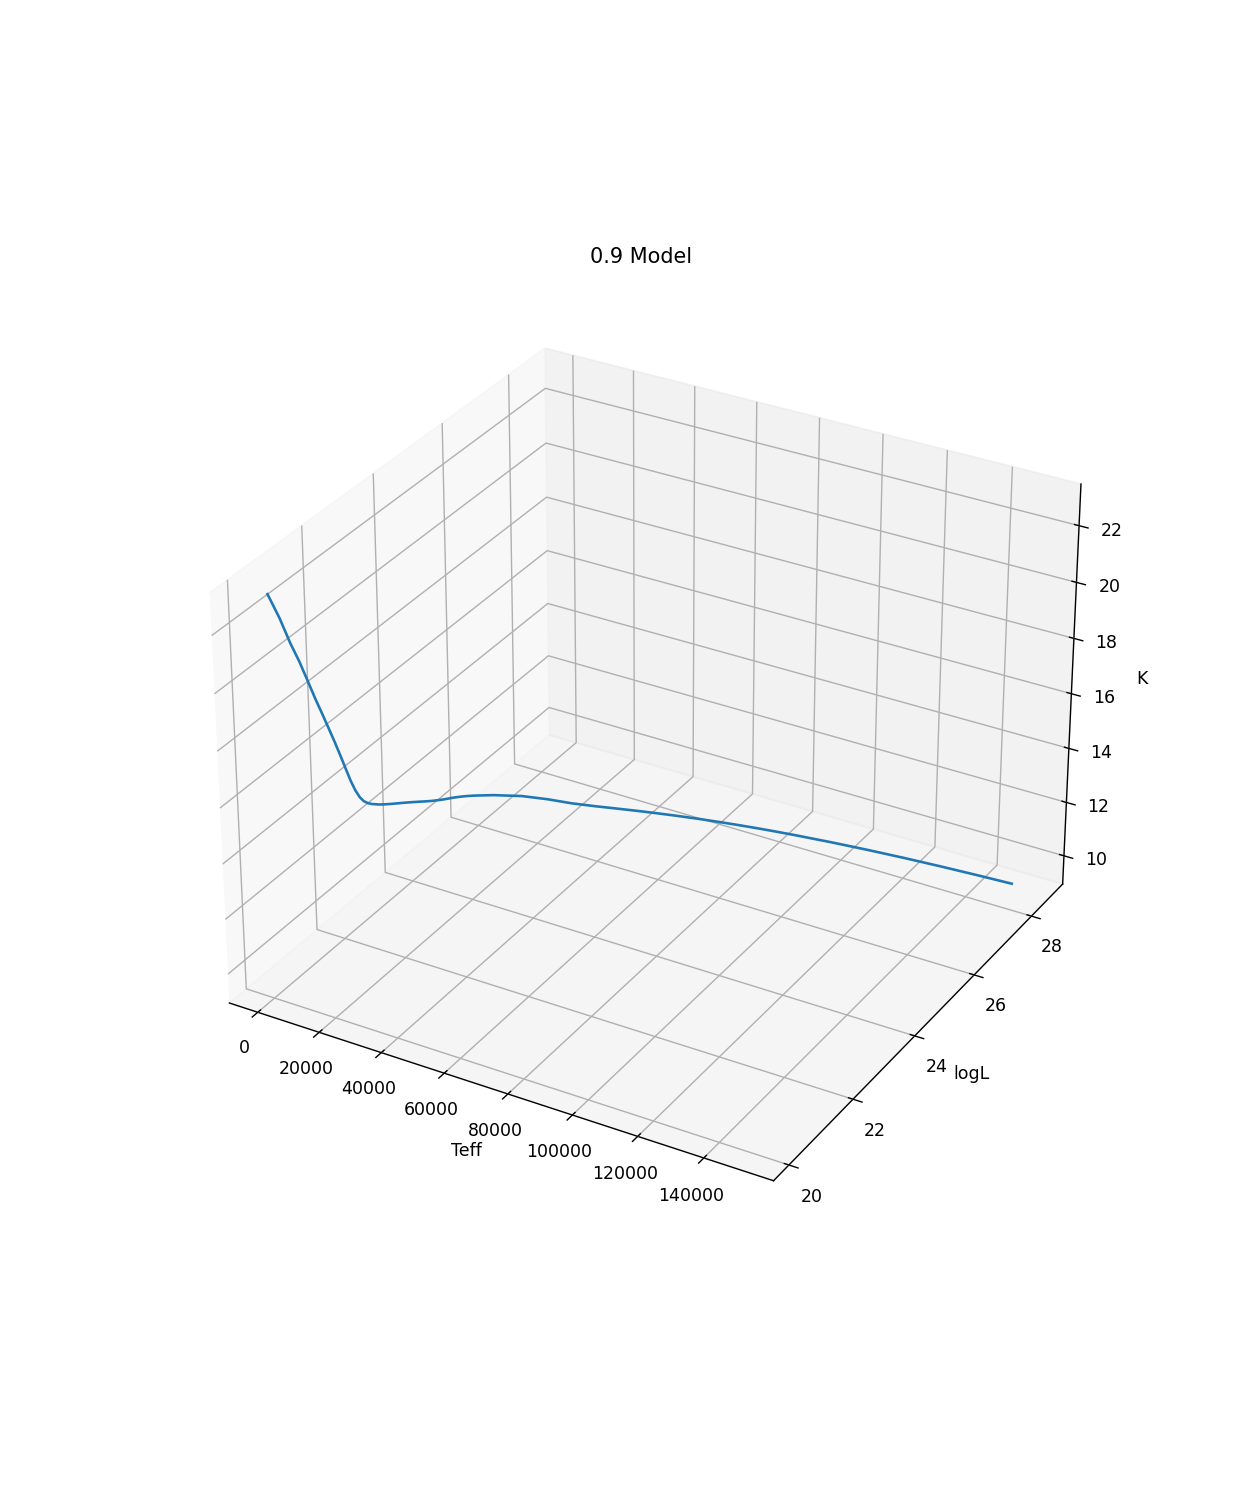

<IPython.core.display.Javascript object>


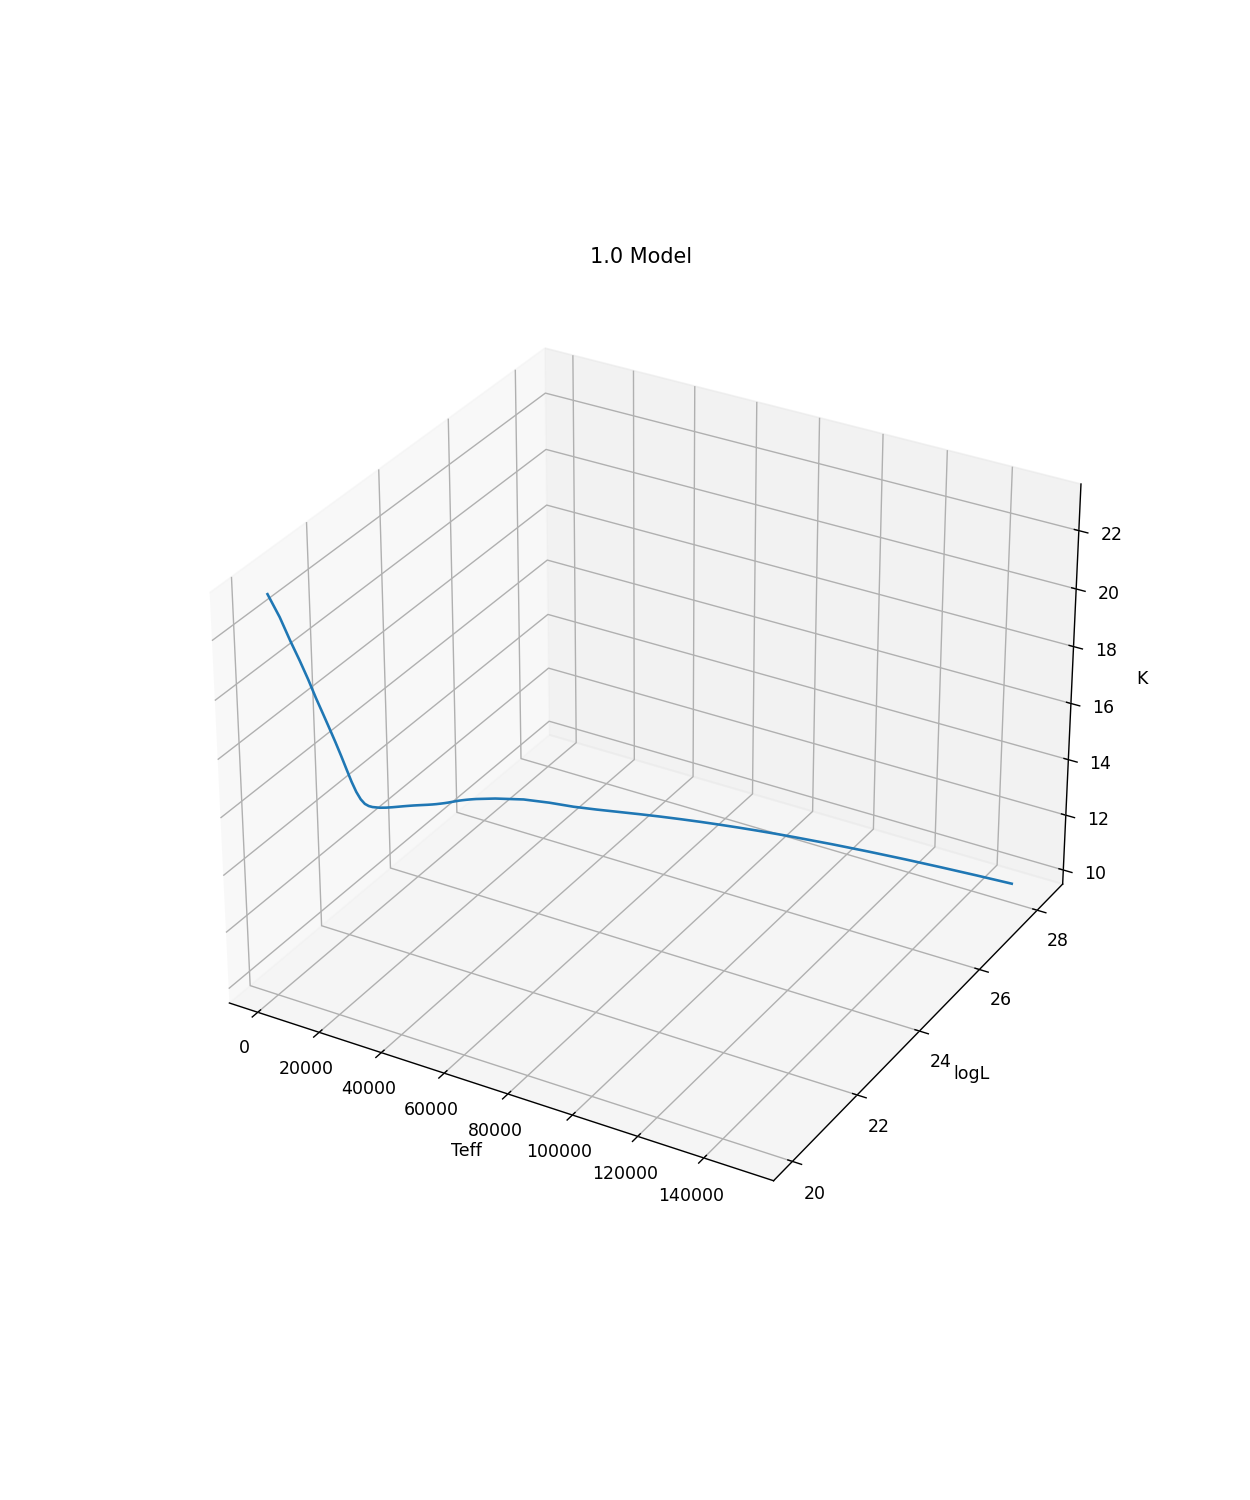

<IPython.core.display.Javascript object>


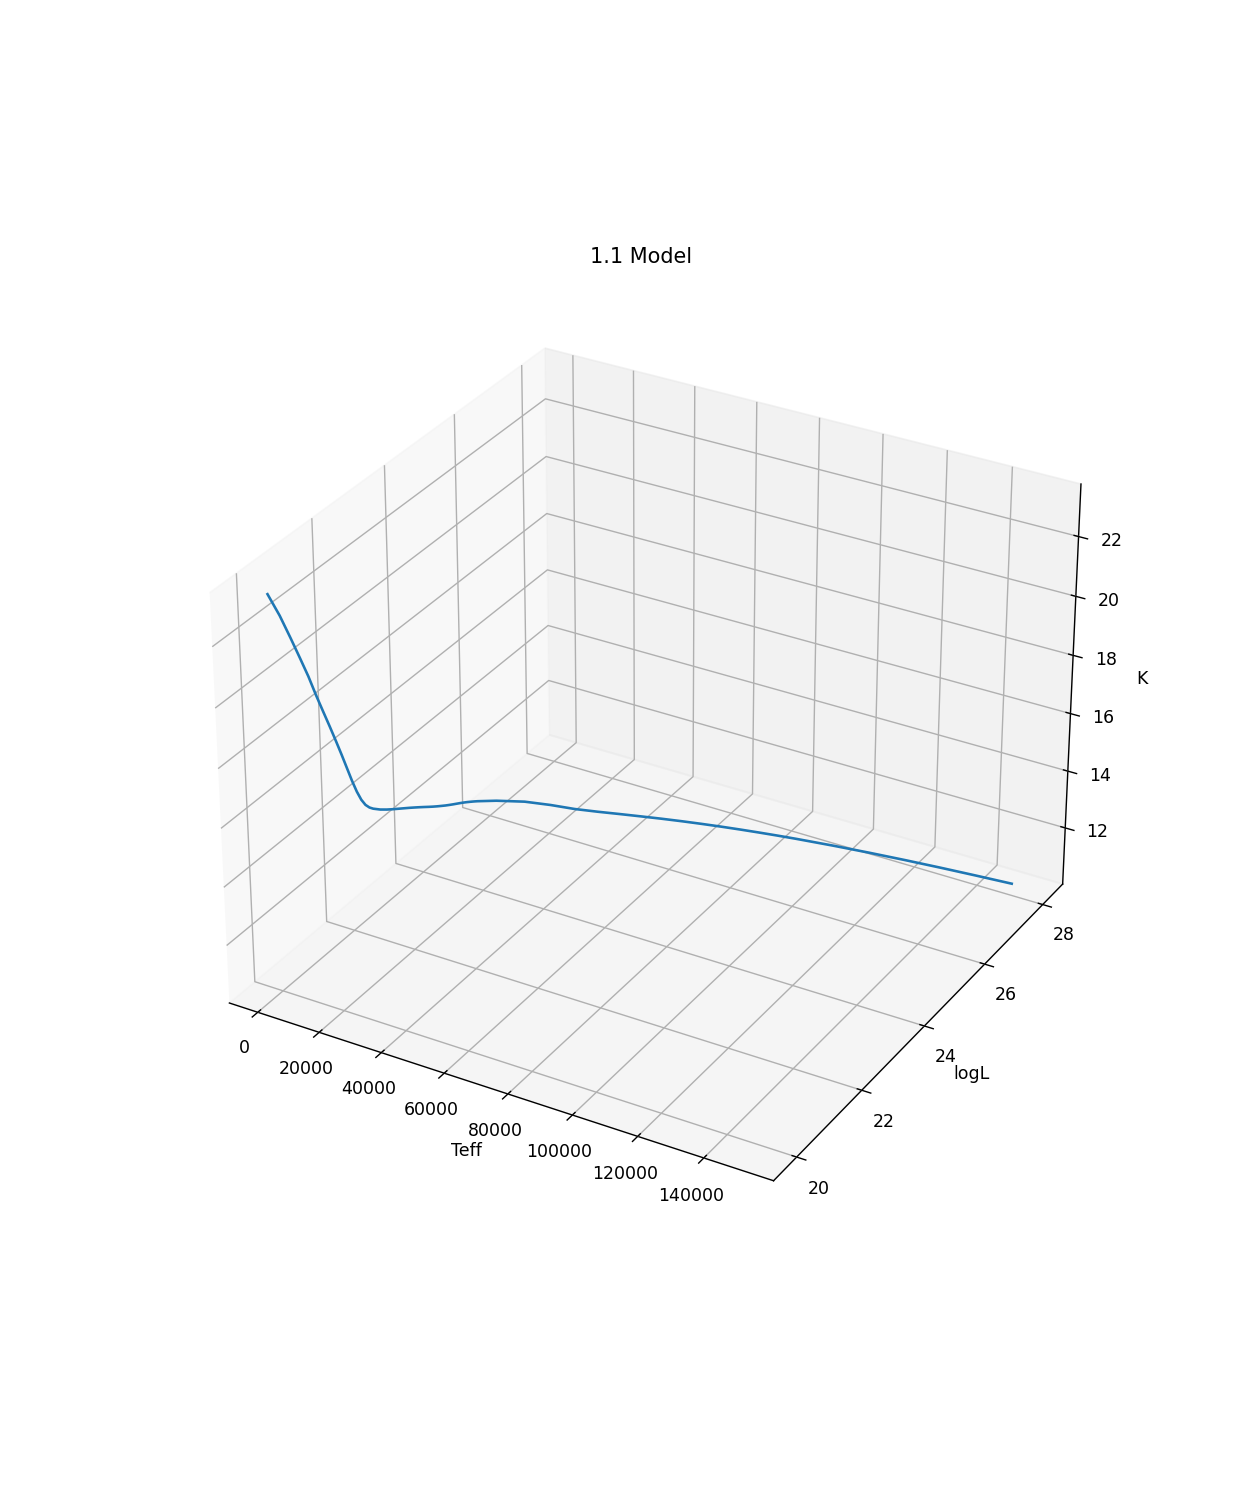

In [ ]:
plotter3D("Teff", "logL", "K")

## Attempt to fit the data

(43, 6)
Coefficients:  [ 0.00000000e+00 -2.57887206e-02 -4.86003117e+01 -3.77368690e-08
  9.39579331e-04  1.16021814e+00]
Y-int:  538.5365007113492
R^2:  0.997862498104929


<IPython.core.display.Javascript object>


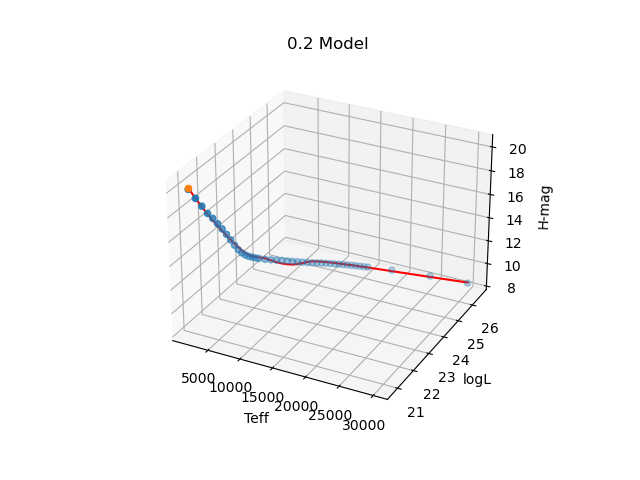

20.15367797834665
(49, 6)
Coefficients:  [ 0.00000000e+00  4.30937089e-03 -4.64148457e+01  7.47291295e-09
 -1.82998982e-04  9.78538991e-01]
Y-int:  561.6328022675492
R^2:  0.9945166606902717


<IPython.core.display.Javascript object>


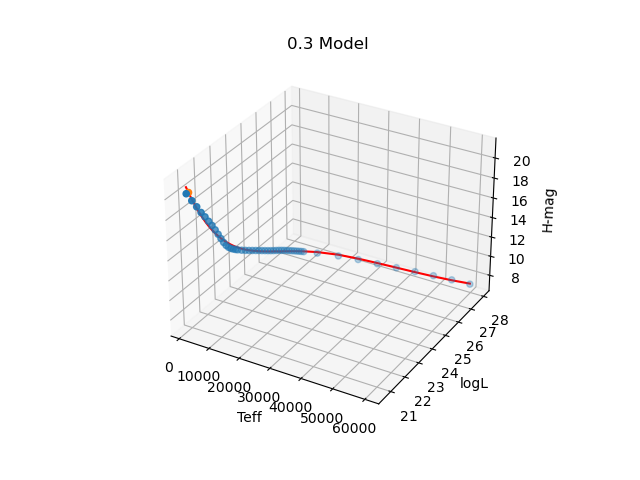

20.330422074315493
(55, 6)
Coefficients:  [ 0.00000000e+00  8.04862351e-03 -3.79468998e+01  1.03647355e-08
 -3.15842896e-04  7.63451781e-01]
Y-int:  476.5684246281495
R^2:  0.9951427477598372


<IPython.core.display.Javascript object>


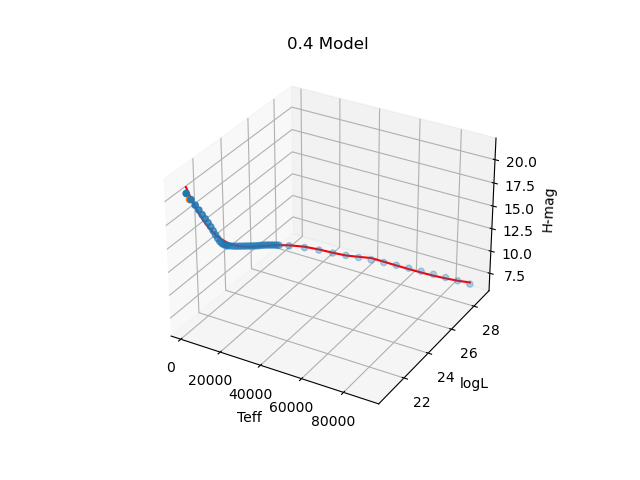

19.814645304466296
(58, 6)
Coefficients:  [ 0.00000000e+00  6.06893914e-03 -3.68660782e+01  6.86689974e-09
 -2.39506332e-04  7.49047798e-01]
Y-int:  460.658151013865
R^2:  0.9950085454857958


<IPython.core.display.Javascript object>


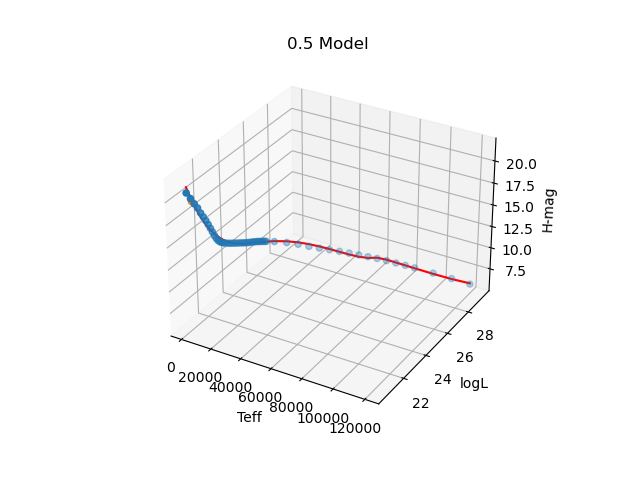

19.55802601318777
(61, 6)
Coefficients:  [ 0.00000000e+00  5.57621350e-03 -3.59111733e+01  5.68689493e-09
 -2.19991929e-04  7.30709423e-01]
Y-int:  448.61343453687414
R^2:  0.9952630532239729


<IPython.core.display.Javascript object>


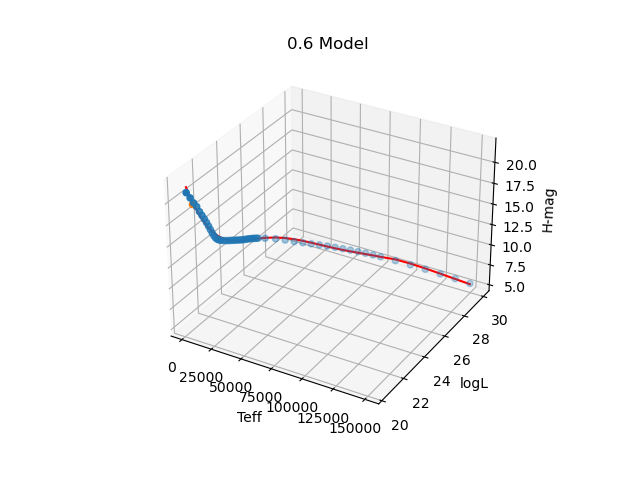

19.308522854183366
(61, 6)
Coefficients:  [ 0.00000000e+00  3.39328065e-03 -3.41650950e+01  3.03304180e-09
 -1.35671874e-04  7.03082701e-01]
Y-int:  424.7953374701825
R^2:  0.9933867334241665


<IPython.core.display.Javascript object>


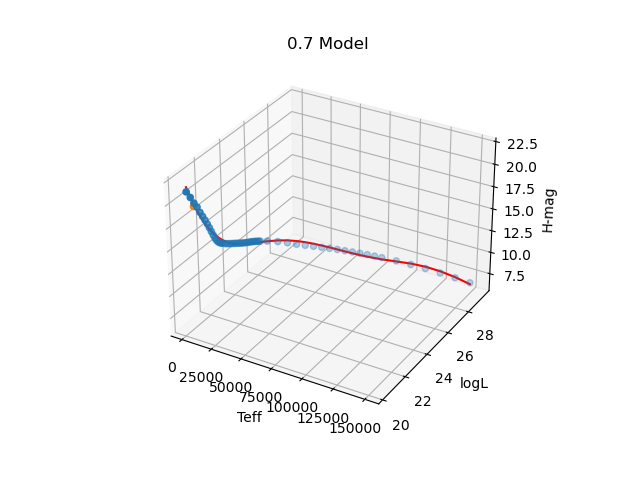

19.206844184308977
(61, 6)
Coefficients:  [ 0.00000000e+00  7.27574200e-03 -1.89666851e+01  4.28759563e-09
 -2.71030583e-04  3.22539438e-01]
Y-int:  270.8513459095339
R^2:  0.9911558939140109


<IPython.core.display.Javascript object>


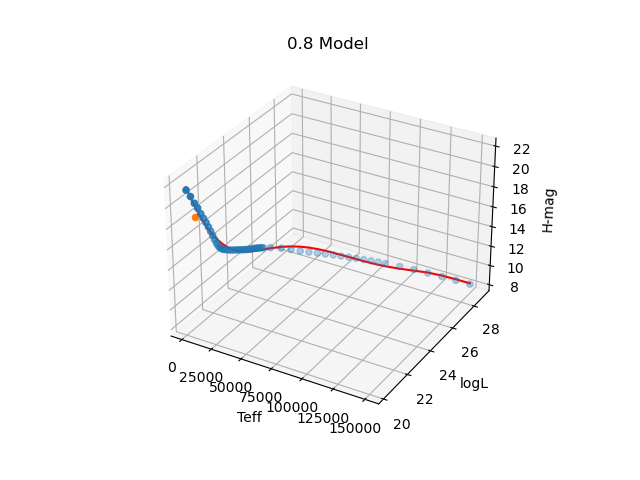

18.3548643705374
(61, 6)
Coefficients:  [ 0.00000000e+00 -1.05184390e-02 -7.09077602e+01 -3.33234314e-09
  3.62217489e-04  1.66730153e+00]
Y-int:  779.2128967634077
R^2:  0.9925946536780329


<IPython.core.display.Javascript object>


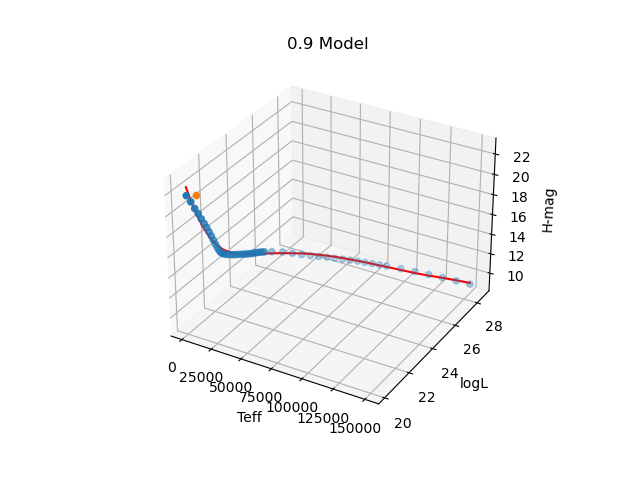

21.188846607633536
(61, 6)
Coefficients:  [ 0.00000000e+00 -8.24334946e-03 -6.56423801e+01 -1.98978604e-09
  2.81005554e-04  1.53630086e+00]
Y-int:  725.2363845392507
R^2:  0.9926873008538611


<IPython.core.display.Javascript object>


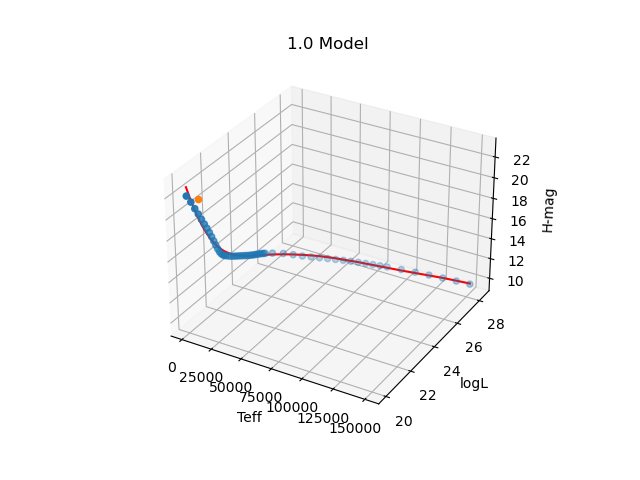

20.937954703480045
(61, 6)
Coefficients:  [ 0.00000000e+00 -6.91817911e-03 -6.17990781e+01 -1.31443104e-09
  2.34521316e-04  1.44525522e+00]
Y-int:  684.0216706480013
R^2:  0.9924307162758109


<IPython.core.display.Javascript object>


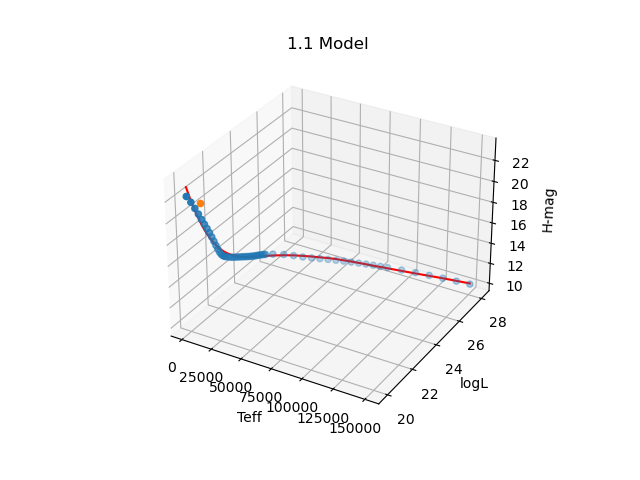

20.81290213774969


In [ ]:
files = ['WD_Tables\Table_Mass_{:.1f}'.format(m) for m in np.arange(0.2, 1.2, 0.1)]
for file in files:
    mdf = pd.read_csv(file, header=1, usecols=['Teff', 'Mbol','H', 'K', 'Age'], delim_whitespace=True)
    # Remove additional headers
    rw = np.where(mdf['Teff'] == 'Teff')[0][0]
    mdf = mdf.drop([rw-1, rw])

    # Get Log L
    mdf['Mbol'] = np.log10(10**(-(mdf['Mbol'].astype(float) - 4.75)/2.5) * (3.8e26))
    mdf = mdf.rename({'Mbol': 'logL'}, axis=1)

    x = mdf['Teff'][:rw-1].astype(float)
    y = mdf['logL'][:rw-1]
    z = mdf['H'][:rw-1].astype(float)
    data_xy = np.array([x,y])
    
    
    poly = PolynomialFeatures(degree=2)
    X_t = poly.fit_transform(data_xy.transpose())
    print(X_t.shape)

    clf = LinearRegression()
    clf.fit(X_t, z)
    z_pred = clf.predict(X_t)
    print("Coefficients: ", clf.coef_)
    print("Y-int: ", clf.intercept_)
    print("R^2: ", clf.score(X_t, z))

    fig = plt.figure()
    ax = plt.subplot(projection='3d')
    ax.plot(x, y, z_pred, 'r') # fit line
    ax.scatter(x, y, z)
    # Add prediction
    z = clf.coef_[1]*1500 + clf.coef_[2]*20.8 + clf.coef_[3]*(1500**2) + clf.coef_[4]*1500*20.8 + clf.coef_[5]*(20.8**2) + clf.intercept_
    print(z)
    ax.scatter(1500, 20.8, z)
    plt.title(file[-3:] + " Model")
    ax.set_xlabel("Teff")
    ax.set_ylabel("logL")
    ax.set_zlabel("H-mag")
    plt.show()

## Interpolation Code Strategies

### Strat 1: No scipy

In [ ]:
# Make master dataframe
def make_master_df(filters):
    """
    Makes the master dataframe for all masses ranging from 0.2 to 1.1 
    solar masses.
    
    Paramaters:
        - filters: [String] -> a string of filters
    Returns:
        A DataFrame of the filters, age and mass
    """
    files = ['WD_Tables\Table_Mass_{:.1f}'.format(m) for m in np.arange(0.2, 1.2, 0.1)]

    mdf = pd.DataFrame()

    for file in files:
        mdf1 = pd.read_csv(file, header=1, usecols=filters+['Age'], delim_whitespace=True)
        # Remove Helium data
        rw = np.where(mdf1['Age'] == 'NUV')[0][0]
        lr = len(mdf1)-1
        mdf1.insert(3, "Mass", float(file[-3:]))
        mdf1 = mdf1[:rw-1].astype(float)
        mdf = pd.concat([mdf, mdf1])
    return mdf

def make_mass_df(mass, filters):
    """
    Makes the master dataframe for a specific mass with the specified
    filters.
    
    Paramaters:
        - mass:    float    -> a float of the mass containing a precision of 
                               one decimal place
        - filters: [String] -> a string of filters
    Returns:
        A DataFrame of the filters, age and mass
    """
    file = 'WD_Tables\Table_Mass_{:.1f}'.format(mass)

    mdf1 = pd.read_csv(file, header=1, usecols=filters+['Age'], delim_whitespace=True)
    # Remove Helium data
    rw = np.where(mdf1['Age'] == 'NUV')[0][0]
    lr = len(mdf1)-1
    mdf1.insert(3, "Mass", float(file[-3:]))
    mdf1 = mdf1[:rw-1].astype(float)
    
    return mdf1



"""


solar_m = 0.93
mbounds = (np.around(np.floor(10*solar_m)/10, decimals=1), np.around(np.floor(10*solar_m)/10 + 0.1, decimals=1))
mbounds

df = mdf.loc[mdf["Mass"] == mbounds[0]]
#print(df)
age_bounds = df.iloc[(df["Age"]-1.345e10).abs().argsort()[:2]][["H1", 'Age']].sort_values("Age", ascending=False).values
f = interp1d(age_bounds[:,1:].flatten(), age_bounds[:,:-1].flatten())
mag = f(1.345e10)
#print(mag)
age_bounds

findMags(mdf, solar_m, 1.215e10, ["H1", "K"])
"""
solar_m = 0.93
age = 1.215e10
count = 0
while age > 1.:
    findMags(mdf, solar_m, age, ["H1", "K"])
    count += 1
    age -= 0.2e7
print(count)



6075


In [ ]:
def findAges(solar_m, filters, filter_vals):
    """
    Given the solar mass in a range of 0.2 to 1.1 inclusively, interpolate
    linearly from the upper and lower bounds (from the white dwarf cooling 
    models) with respect to the filter values.
    Parameters:
        - solar_m:     float    -> must be rounded to the nearest tenth decimal
        - filters:     [String] -> a list containing the filters as strings.
        - filter_vals: [float]  -> a list of values for filter magnitudes in the order of filters
        
    Returns:
        - A list of ages based on linear interpolation of each filter
    """
    # Make a dataframe with the appropriate mass values
    df = make_mass_df(solar_m, filters)
    
    # would contain len(filters) ages as each filter interpolation results in a slightly different age
    ages = [] 
    for i in range(len(filters)):
        # For each filter, the upper and lower bounds of the dataframe is found with respect to the filter value
        fil_bounds = df.iloc[(df[filters[i]]-filter_vals[i]).abs().argsort()[:2]][[filters[i], 'Age']].values
        
        # get slope for the (filter_max -> filter_min) and (age_max -> age_min)
        diff = fil_bounds[0] - fil_bounds[1]
        slope = diff[0]/diff[1]
        b = fil_bounds[0][0] - (slope * fil_bounds[0][1])
        # y = mx + b (x is age, y is filter); solve for x
        age = (filter_vals[i] - b)/slope
        ages.append(age)
    return ages

def findAgesV2(solar_m, filters, filter_vals):
    """
    Using scipy's interp2D, interpolate the white dwarf mass from
    each filter.
    Parameters:
        - solar_m:     float    -> must be rounded to the nearest tenth decimal
        - filters:     [String] -> a list containing the filters as strings.
        - filter_vals: [float]  -> a list of values for filter magnitudes in the order of filters
        
    Returns:
        - A list of ages based on linear interpolation of each filter
    """
    # Make a dataframe with the appropriate mass values
    df = make_mass_df(solar_m, filters)
    
    # would contain len(filters) ages as each filter interpolation results in a slightly different age
    ages = [] 
    for i in range(len(filters)):
        # For each filter, the upper and lower bounds of the dataframe is found with respect to the filter value
        fil_bounds = df.iloc[(df[filters[i]]-filter_vals[i]).abs().argsort()[:2]][[filters[i], 'Age']].values
        
        # y = f(x) (y would be age, x is the filter magnitude)
        f = interp1d(fil_bounds[:,:-1].flatten(), fil_bounds[:,1:].flatten())
        age = f(filter_vals[i])
        ages.append(age)
    return ages
    
              
    
    
    

In [ ]:
def findMags(mdf, solar_m, age, filters):
    """
    Version 1 O(n): 
            <<ESTIMATES>>
            - runs    = 150*time(s) + 0.87
            - time(s) = 0.007*runs - 0.01
    Given the solar mass in a range of 0.2 to 1.1 inclusively, interpolate
    linearly from the upper and lower bounds (from the white dwarf cooling 
    models) with respect to the age.
    Parameters:
        - mdf:         DataFrame -> the master dataframe containing the WD Cooling Models
        - solar_m:     float     -> must be rounded to the nearest tenth decimal
        - filters:     [String]  -> a list containing the filters as strings.
        - age:         [float]   -> the estimated age of the white dwarf
        
    Returns:
        - The estimated magnitude for the each filter in the order of filters
    """
    
    # Make array to hold magnitudes. Elm 0 is are the interp values for the lowerbound; Elm 1 is the upper.
    mags = np.zeros((2,len(filters)))
    # TODO: Check age limits for dataframes
    
    # Makes the bounds and ensures floats have one decimal (avoiding floating point errors)
    mbounds = (np.around(np.floor(10*solar_m)/10, decimals=1), np.around(np.floor(10*solar_m)/10 + 0.1, decimals=1))
    #print("Mass bounds:\n", mbounds)
    
    # Outer loop runs twice only
    for m in range(len(mbounds)):
        # Make sub dataframe for specific mass
        df = mdf.loc[mdf["Mass"] == mbounds[m]]
        #print("\nSpecific Mass dataframe:\n", df)
        
        # For each filter, the upper and lower bounds of the dataframe is found with respect to the filter value
        for i in range(len(filters)):
            #print(filters[i])
            sub = df["Age"]-age
            age_upper = df.loc[[df.loc[sub > 0, "Age"].idxmin()]][[filters[i], 'Age']]
            age_lower = df.loc[[df.loc[sub < 0, "Age"].idxmax()]][[filters[i], 'Age']]
            age_bounds = pd.concat([age_upper, age_lower]).values
            #print("Age bounds:\n", age_bounds)

            # y = f(x) (y would be magnitude, x is the age)
            f = interp1d(age_bounds[:,1:].flatten(), age_bounds[:,:-1].flatten())
            
            # Add the magnitude in the bound array in the order of the filter array ie. elm 0 is filt 0's magnitude
            mags[m][i] = f(age)
            #print("Current mags:\n", mags)
    
    # Calculates the magnitude for the age given 
    fract = (solar_m - mbounds[0])/(mbounds[1]-mbounds[0])
    #print("Fract val:\n", fract)
    plus = fract * (mags[1]-mags[0])
    #print("Plus:\n", plus)
    fmags = mags[0] + plus
    
    return fmags

<IPython.core.display.Javascript object>


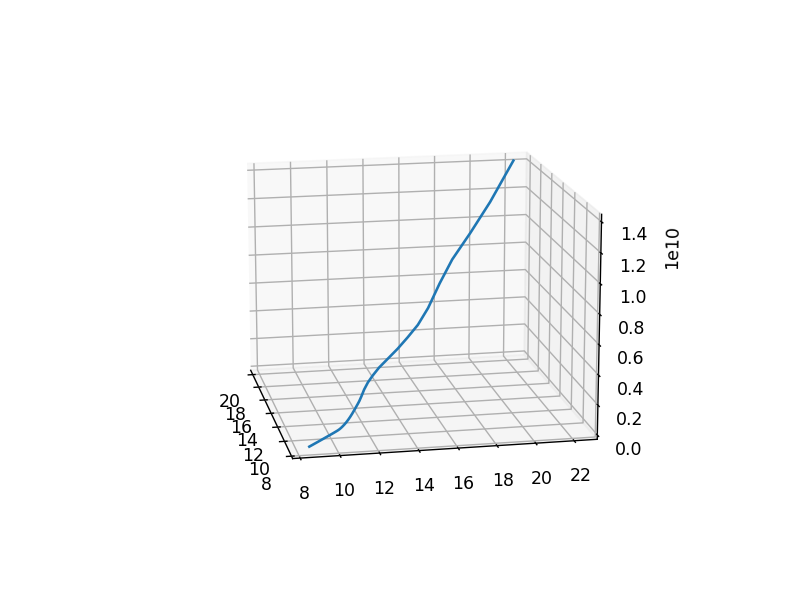

In [ ]:
ax = plt.axes(projection='3d')
ax.plot3D(df['H1'].values,df['K'].values,df['Age'].values)
ax.invert_xaxis()


In [ ]:
make_master_df